In [2]:

import networkx as nx
import pickle
import pandas as pd
import itertools
import os

In [2]:

graph_files = ["English_Liguori.gpickle", "French_Liguori.gpickle", "Spanish_Liguori.gpickle", "German_Liguori.gpickle"]
graphs = []

for f in graph_files:
    graph_name = os.path.splitext(os.path.basename(f))[0]  # graph_id = filename without extension
    if f.endswith(".gpickle"):
        G = nx.read_gpickle(f)
    else:
        with open(f, "rb") as file:
            G = pickle.load(file)
    graphs.append((graph_name, G))

In [3]:

combined = nx.MultiDiGraph()

for graph_id, G in graphs:
    # Add nodes with source graph info
    for n, data in G.nodes(data=True):
        if n not in combined:
            combined.add_node(n, **data, source_graph=[graph_id])
        else:
            combined.nodes[n]['source_graph'].append(graph_id)
    # Add edges with source graph info
    for u, v, key, data in G.edges(keys=True, data=True):
        new_key = f"{key}_{graph_id}"
        combined.add_edge(u, v, key=new_key, **data, source_graph=graph_id)


In [4]:
len(combined.nodes())

463

In [5]:
len(combined.edges())

7302

In [6]:

from rapidfuzz import fuzz

In [15]:
print(fuzz.ratio("benziger", "benziger brothers"))

64.0


In [7]:
print(fuzz.token_set_ratio("benziger", "benziger brothers")) 

100.0


In [8]:

import re

def clean_name(name: str) -> str:
    # Lowercase
    n = name.lower()
    # Remove common words and punctuation
    n = re.sub(r'\b(ltd|co|inc|press|publishing|house|editions|edition|books?)\b', '', n)
    n = re.sub(r'[^\w\s]', '', n)
    # Collapse whitespace
    n = re.sub(r'\s+', ' ', n).strip()
    return n

from collections import defaultdict

def ask_and_merge_candidates(G, candidates):
    merged_map = {}  # keep track of which nodes were merged
    skip_all = False

    for n1, n2, score in candidates:
        if skip_all:
            break
        if n1 not in G or n2 not in G:
            continue  # node already merged

        print(f"\n❓ Possible duplicate:\n   {n1} ↔ {n2}  (similarity: {score})")
        choice = input("Merge these? [y]es / [n]o / [s]kip all: ").strip().lower()

        if choice == 's':
            skip_all = True
            continue
        if choice != 'y':
            continue

        # Merge nodes n2 into n1
        merge_nodes(G, n1, n2)
        merged_map[n2] = n1
        print(f"✅ Merged '{n2}' into '{n1}'")

    return merged_map

In [9]:

def find_candidate_duplicates(G, threshold=80):
    node_names = {n: clean_name(str(n)) for n in G.nodes()}
    candidates = []
    nodes_list = list(G.nodes())

    for i in range(len(nodes_list)):
        for j in range(i+1, len(nodes_list)):
            n1, n2 = nodes_list[i], nodes_list[j]
            sg1 = set(G.nodes[n1].get('source_graph', []))
            sg2 = set(G.nodes[n2].get('source_graph', []))
            # only consider nodes from different graphs
            if sg1.isdisjoint(sg2):
                clean1 = node_names[n1]
                clean2 = node_names[n2]
                score = fuzz.token_set_ratio(clean1, clean2)
                if clean1 == clean2 or score >= threshold:
                    candidates.append((n1, n2, score))
    candidates.sort(key=lambda x: x[2], reverse=True)
    return candidates


In [10]:

def merge_nodes(G, keep, remove):
    # merge attributes
    for key, val in G.nodes[remove].items():
        if key not in G.nodes[keep]:
            G.nodes[keep][key] = val
        else:
            keep_val = G.nodes[keep][key]

            # Handle source_graph specially
            if key == 'source_graph':
                G.nodes[keep][key] = list(set(keep_val + val))

            # Handle publications (list of dicts)
            elif key == 'publications' and isinstance(keep_val, list) and isinstance(val, list):
                # Deduplicate based on title + year combo (or customize)
                seen = set()
                merged = []
                for pub in keep_val + val:
                    # Create a simple signature to avoid duplicates
                    title = pub.get('title')
                    years = tuple(pub.get('years', [])) if isinstance(pub.get('years'), list) else pub.get('years')
                    sig = (title, years)
                    if sig not in seen:
                        seen.add(sig)
                        merged.append(pub)
                G.nodes[keep][key] = merged

            # Handle lists of hashable types (e.g., list of strings)
            elif isinstance(keep_val, list) and isinstance(val, list):
                try:
                    G.nodes[keep][key] = list(set(keep_val + val))
                except TypeError:
                    # Fallback to concatenation if not hashable
                    G.nodes[keep][key] = keep_val + val

            # If one value is missing or not list, just override conservatively
            else:
                # You could also define a more sophisticated merge rule here if needed
                if keep_val != val:
                    # store both in a list if they are different
                    if not isinstance(keep_val, list):
                        keep_val = [keep_val]
                    if val not in keep_val:
                        keep_val.append(val)
                    G.nodes[keep][key] = keep_val

    # redirect all edges from 'remove' to 'keep'
    for u, v, key, data in list(G.in_edges(remove, keys=True, data=True)):
        G.add_edge(u if u != remove else keep,
                   v if v != remove else keep,
                   key=key, **data)
    for u, v, key, data in list(G.out_edges(remove, keys=True, data=True)):
        G.add_edge(u if u != remove else keep,
                   v if v != remove else keep,
                   key=key, **data)

    # finally remove the node
    G.remove_node(remove)


In [11]:
candidates = find_candidate_duplicates(combined, threshold=80)

In [26]:
print(f"Found {len(candidates)} possible duplicate publisher pairs.")

Found 21 possible duplicate publisher pairs.


In [12]:

if candidates:
    merged_map = ask_and_merge_candidates(combined, candidates)
    print(f"\n✅ Finished merging. {len(merged_map)} nodes were merged.")


❓ Possible duplicate:
   Thomas Richardson & Son ↔ thomas  (similarity: 100.0)


Merge these? [y]es / [n]o / [s]kip all:  n



❓ Possible duplicate:
   Fr. Pustet ↔ Pustet  (similarity: 100.0)


Merge these? [y]es / [n]o / [s]kip all:  y


✅ Merged 'Pustet' into 'Fr. Pustet'

❓ Possible duplicate:
   Thomas Sweeney ↔ thomas  (similarity: 100.0)


Merge these? [y]es / [n]o / [s]kip all:  n



❓ Possible duplicate:
   J. Murphy ↔ Murphy  (similarity: 100.0)


Merge these? [y]es / [n]o / [s]kip all:  y


✅ Merged 'Murphy' into 'J. Murphy'

❓ Possible duplicate:
   Benziger Brothers ↔ benziger  (similarity: 100.0)


Merge these? [y]es / [n]o / [s]kip all:  y


✅ Merged 'benziger' into 'Benziger Brothers'

❓ Possible duplicate:
   Benziger Brothers ↔ Benziger  (similarity: 100.0)


Merge these? [y]es / [n]o / [s]kip all:  y


✅ Merged 'Benziger' into 'Benziger Brothers'

❓ Possible duplicate:
   mame ↔ Mame  (similarity: 100.0)


Merge these? [y]es / [n]o / [s]kip all:  y


✅ Merged 'Mame' into 'mame'

❓ Possible duplicate:
   fischer ↔ Fischer  (similarity: 100.0)


Merge these? [y]es / [n]o / [s]kip all:  y


✅ Merged 'Fischer' into 'fischer'

❓ Possible duplicate:
   larumbe ↔ Larumbe  (similarity: 100.0)


Merge these? [y]es / [n]o / [s]kip all:  y


✅ Merged 'Larumbe' into 'larumbe'

❓ Possible duplicate:
   deckherr ↔ Deckherr  (similarity: 100.0)


Merge these? [y]es / [n]o / [s]kip all:  y


✅ Merged 'Deckherr' into 'deckherr'

❓ Possible duplicate:
   lefevbre ↔ Lefevre  (similarity: 93.33333333333333)


Merge these? [y]es / [n]o / [s]kip all:  y


✅ Merged 'Lefevre' into 'lefevbre'

❓ Possible duplicate:
   fischer ↔ Fleischer  (similarity: 87.5)


Merge these? [y]es / [n]o / [s]kip all:  n



❓ Possible duplicate:
   desclee ↔ Desclée  (similarity: 85.71428571428571)


Merge these? [y]es / [n]o / [s]kip all:  y


✅ Merged 'Desclée' into 'desclee'

❓ Possible duplicate:
   vagner ↔ Wagner  (similarity: 83.33333333333333)


Merge these? [y]es / [n]o / [s]kip all:  y


✅ Merged 'Wagner' into 'vagner'

❓ Possible duplicate:
   pillot ↔ Pillet  (similarity: 83.33333333333333)


Merge these? [y]es / [n]o / [s]kip all:  n



❓ Possible duplicate:
   Walder ↔ Walter  (similarity: 83.33333333333333)


Merge these? [y]es / [n]o / [s]kip all:  n



❓ Possible duplicate:
   Pillet ↔ Piller  (similarity: 83.33333333333333)


Merge these? [y]es / [n]o / [s]kip all:  y


✅ Merged 'Piller' into 'Pillet'

❓ Possible duplicate:
   vial ↔ Avrial  (similarity: 80.0)


Merge these? [y]es / [n]o / [s]kip all:  n



✅ Finished merging. 12 nodes were merged.


In [28]:

len(combined.nodes())

451

In [28]:
len(combined.edges())

7302

In [13]:

title_map = pd.read_excel("en_spa_fr_ger_liguori_titles_unified_3.xlsx")  # Columns: title_lang1, title_lang2, etc.
language_cols = ['EN', 'SPA', 'FR', 'GER']

In [14]:

title_to_nodes = {}  # key = title, value = list of nodes containing this title
for n, data in combined.nodes(data=True):
    for pub in data['publications']:
        title = pub['title']
        if title not in title_to_nodes:
            title_to_nodes[title] = []
        title_to_nodes[title].append((n, pub))  # store node + publication info

In [15]:

def clean_years(years):
    """
    Convert a list of years to integers, skip invalid/missing entries.
    """
    clean = []
    for y in years:
        if pd.isna(y):
            continue
        try:
            clean.append(int(y))
        except:
            pass  # skip non-numeric strings
    return sorted(clean)


In [16]:

def clean_editions(ed):
    """
    Convert editions to a single numeric value for weighting.
    If it's a list, take the max.
    """
    if isinstance(ed, list):
        # Filter numeric values
        nums = [int(x) for x in ed if pd.notna(x)]
        return max(nums) if nums else 1
    try:
        return int(ed)
    except:
        return 1


In [17]:

# existing_edges = set()

def add_edge_with_attributes(G, publisher_A, publisher_B, title, source_years, target_years,
                             source_translator, target_translator, source_num_editions,
                             target_num_editions, source_place, target_place, weight, relation, key):
    G.add_edge(publisher_A, publisher_B, title=title, source_years=source_years, target_years=target_years,
               source_translator=source_translator, target_translator=target_translator,
               source_num_editions=source_num_editions, target_num_editions=target_num_editions,
               source_place=source_place, target_place=target_place, weight=weight, relation=relation, key=key)


In [18]:

import itertools

def add_cross_language_edges(G, title_map_df, existing_edges):
    """
    Add directed edges between publishers when their publications correspond
    across languages (based on the Excel title mapping).
    """

    # Extract columns for the relevant language titles
    lang_cols = ["EN", "SPA", "FR", "GER"]
    title_dict = {}

    # Build a lookup from each title to its equivalent titles in other languages
    for _, row in title_map_df.iterrows():
        titles = [row[col] for col in lang_cols if pd.notna(row[col])]
        for t in titles:
            title_dict[t] = [other for other in titles if other != t]

    # Loop over all pairs of publishers
    for pub_A, pub_B in itertools.combinations(G.nodes, 2):
        publications_A = G.nodes[pub_A].get('publications', [])
        publications_B = G.nodes[pub_B].get('publications', [])

        # Compare publications across language
        for publication_A in publications_A:
            title_A = publication_A.get('title')
            if title_A not in title_dict:
                continue

            matching_titles = set(title_dict[title_A])  # translations

            for publication_B in publications_B:
                title_B = publication_B.get('title')
                if title_B not in matching_titles:              
                    continue

                years_A = publication_A.get('years', [])
                years_B = publication_B.get('years', [])

                # Ensure translators are lists
                translators_A = publication_A.get('translator', [])
                translators_B = publication_B.get('translator', [])
                if not isinstance(translators_A, list):
                    translators_A = [] if pd.isna(translators_A) else [translators_A]
                if not isinstance(translators_B, list):
                    translators_B = [] if pd.isna(translators_B) else [translators_B]

                # Handle editions and place
                editions_A = publication_A.get('editions', 1)
                editions_B = publication_B.get('editions', 1)
                place_A = publication_A.get('place')
                place_B = publication_B.get('place')

                years_A = clean_years(years_A) if isinstance(years_A, list) else []
                years_B = clean_years(years_B) if isinstance(years_B, list) else []

                # Determine edge direction and type
                edge_counter = 0

                # Co-publication
                if title_A != title_B and len(years_A)>0 and len(years_B)>0 and years_A[0] == years_B[0]:
                    edge_key = f"sync_{pub_A}_{pub_B}_{title_A}_{title_B}_{len(existing_edges)}" # PUT STH ELSE HERE THAN LEN OF EXISTING EDGES; SAY years_A[0]
                    if edge_key not in existing_edges:
                        weight = max(clean_editions(editions_A), clean_editions(editions_B))
                        add_edge_with_attributes(
                            G, pub_A, pub_B, f"{title_A} ↔ {title_B}", years_A, years_B,
                            translators_A, translators_B, editions_A, editions_B,
                            place_A, place_B, weight, 'synchronization', edge_key
                        )
                        existing_edges.add(edge_key)

                # Reprint or retranslation (directed)
                elif years_A and years_B:
                    if years_A[0] < years_B[0]:
                        relation_type = (
                            'cross_reprint' if set(translators_A) == set(translators_B)
                            else 'precedence'
                        )
                        edge_key = f"{relation_type}_{pub_A}_{pub_B}_{title_A}_{title_B}_{len(existing_edges)}"
                        if edge_key not in existing_edges:
                            weight = clean_editions(editions_B)
                            add_edge_with_attributes(
                                G, pub_A, pub_B, f"{title_A} → {title_B}", years_A, years_B,
                                translators_A, translators_B, editions_A, editions_B,
                                place_A, place_B, weight, relation_type, edge_key
                            )
                            existing_edges.add(edge_key)
                    elif years_B[0] < years_A[0]:
                        relation_type = (
                            'cross_reprint' if set(translators_A) == set(translators_B)
                            else 'precedence'
                        )
                        edge_key = f"{relation_type}_{pub_B}_{pub_A}_{title_B}_{title_A}_{len(existing_edges)}"
                        if edge_key not in existing_edges:
                            weight = clean_editions(editions_A)
                            add_edge_with_attributes(
                                G, pub_B, pub_A, f"{title_B} → {title_A}", years_B, years_A,
                                translators_B, translators_A, editions_B, editions_A,
                                place_B, place_A, weight, relation_type, edge_key
                            )
                            existing_edges.add(edge_key)


In [19]:

existing_edges = set(
    f"{u}_{v}_{k}" for u, v, k in combined.edges(keys=True)
)

add_cross_language_edges(combined, title_map, existing_edges)

In [40]:

len(combined.edges())

30497

In [21]:

# EDGES CONNECTING PUBLISHERS THAT RELEASED THE SAME TITLE IN THE SAME YEAR IN TWO DIFFERENT LANGUAGES

sync_edges_key = [
    (u, v, k)
    for u, v, k, data in combined.edges(keys=True, data=True)
    if "sync" in str(k).lower()
]

print(f"🔗 Number of sync edges (by edge_key): {len(sync_edges_key)}")


🔗 Number of sync edges (by edge_key): 261


In [22]:
sync_edges_key[:2]

[('E. Cummiskey',
  'lefort',
  'sync_E. Cummiskey_lefort_The Glories of Mary_Gloires de Marie_7323'),
 ('E. Cummiskey',
  'Cremer',
  'sync_E. Cummiskey_Cremer_The Glories of Mary_Die Herrlichkeiten Mariens_7350')]

In [24]:

sync_edges_key[10]

('John Coyne',
 'Pons y Cía',
 'sync_John Coyne_Pons y Cía_The Selva : or, a collection of matter for sermons and instructions for ecclesiastical retreats and for private spiritual lectures_Selva de materias predicables e instructivas_8240')

In [25]:

reprint_edges = [
    (u, v, k)
    for u, v, k, data in G.edges(keys=True, data=True)
    if str(data.get("relation_type", "")).lower().startswith("cross_")
]

print(f"🔗 Number of reprint edges (by relation_type): {len(reprint_edges)}")


🔗 Number of reprint edges (by relation_type): 0


In [26]:

# WE PICKLE THE COMBINED GRAPH OF ALL PUBLISHERS ACROSS THE 4 LANGUAGES CONNECTED BY TITLES

import pickle

with open('Liguori_19th_Century.pkl', 'wb') as f:
    pickle.dump(combined, f)


TITLES GRAPH


In [6]:
title_map_df = pd.read_excel("en_spa_fr_ger_liguori_titles_unified_3.xlsx")
language_cols = ["EN", "SPA", "FR", "GER"]

title_to_unified = build_title_equivalence(title_map_df, language_cols)

In [31]:
len(title_to_unified)

292

In [7]:

import pandas as pd
import networkx as nx
import itertools
import re
import unicodedata

# -------------------------
# Shared normalization
# -------------------------
def normalize_title(title):
    if not isinstance(title, str):
        return ""
    # Strip accents
    title = unicodedata.normalize('NFKD', title)
    title = "".join(ch for ch in title if not unicodedata.combining(ch))
    # Lowercase
    title = title.lower()
    # Remove punctuation (keep letters and numbers)
    title = re.sub(r"[^a-z0-9]+", " ", title)
    # Collapse whitespace
    title = re.sub(r"\s+", " ", title)
    return title.strip()

# -------------------------
# Build title equivalence
# -------------------------
def build_title_equivalence(title_map_source, language_cols):
    """
    Build a dictionary mapping each language-specific title to a unified multilingual title.
    """
    # Load Excel if a file path is provided
    if isinstance(title_map_source, str):
        title_map_df = pd.read_excel(title_map_source)
    else:
        title_map_df = title_map_source

    title_to_unified = {}
    for _, row in title_map_df.iterrows():
        # Normalize all language columns
        titles = [normalize_title(str(row[col])) for col in language_cols if pd.notna(row[col])]
        if not titles:
            continue
        # Create unified label (sorted to be deterministic)
        unified_title = " / ".join(sorted(set(titles)))
        for t in titles:
            title_to_unified[t] = unified_title
    return title_to_unified


In [ ]:
def inspect_multilingual_nodes(T, n=10):
    """
    Print the first `n` nodes with their attributes, including languages and editions.
    """
    print(f"Inspecting first {n} nodes of the multilingual graph:\n")
    for i, (node, data) in enumerate(T.nodes(data=True)):
        if i >= n:
            break
        print(f"Node: {node}")
        print(f"  Languages: {data['languages']}")
        print(f"  Publishers: {data['publishers']}")
        print(f"  Years: {data['years']}")
        print(f"  Editions: {data['editions']}")
        print(f"  Total editions: {data['total_editions']}")
        print("-" * 60)

inspect_multilingual_nodes(T, n=20)

In [8]:

def build_title_equivalence_raw(title_map_df, language_cols):
    """
    Build a raw mapping from each language-specific title
    to a unified multilingual title label (concatenation of all known forms).
    
    Example:
        EN = "Glories of Mary"
        FR = "Les Gloires de Marie"
        → both map to unified title:
          "Glories of Mary / Les Gloires de Marie"
    """
    title_to_unified = {}
    
    for _, row in title_map_df.iterrows():
        titles = [
            str(row[col]).strip()
            for col in language_cols
            if pd.notna(row[col]) and str(row[col]).strip()
        ]
        if not titles:
            continue
        
        # Create unified label by joining known titles in that row
        unified_title = " / ".join(titles)
        
        # Map each variant to the same unified label
        for t in titles:
            title_to_unified[t] = unified_title
    
    return title_to_unified


In [9]:

graph_to_lang = {
    "English_Liguori": "EN",
    "Spanish_Liguori": "SPA",
    "French_Liguori": "FR",
    "German_Liguori": "GER"
}

In [10]:


def build_multilingual_title_graph_weighted_with_language_editions_1(G, title_map_df, language_cols):
    """
    Build a multilingual title graph where:
    - Nodes = unified multilingual titles
    - Edges = shared publishers
    - Weight = max editions across titles for a shared publisher
    - Node attributes:
        - total_editions: sum of editions across all publishers
        - editions: dict of editions per publisher
        - editions_by_language: dict of dicts per publisher per language
        - languages: set of languages present
        - years: set of publication years
    """
    # --- STEP 1: Build title equivalence ---
    title_to_unified = {}
    for _, row in title_map_df.iterrows():
        titles = [str(row[col]).strip() for col in language_cols if pd.notna(row[col])]
        if not titles:
            continue
        unified_title = " / ".join(titles)
        for t in titles:
            title_to_unified[t] = unified_title

    # --- STEP 2: Initialize nodes ---
    T = nx.MultiDiGraph()
    for unified_title in set(title_to_unified.values()):
        T.add_node(
            unified_title,
            publishers=set(),
            years=set(),
            languages=set(),
            editions={},
            editions_by_language={},
            total_editions=0
        )

    unmapped_titles = set()

    def normalize_editions(ed):
        if ed is None:
            return 0
        if isinstance(ed, list):
            flat = []
            for e in ed:
                if isinstance(e, list):
                    flat.extend(e)
                else:
                    flat.append(e)
            return int(sum(float(x) for x in flat if pd.notna(x)))
        if isinstance(ed, (int, float)):
            return int(ed)
        try:
            return int(float(ed))
        except:
            return 0

    # --- STEP 3: Populate node attributes ---
    for u, v, data in G.edges(data=True):
        raw_title = data.get("title")
        if not raw_title:
            continue

        unified_title = title_to_unified.get(raw_title)
        if unified_title is None:
            unmapped_titles.add(raw_title)
            continue

        # --- Extract years ---
        years = []
        for ylist in (data.get("source_years", []), data.get("target_years", [])):
            if isinstance(ylist, list):
                for y in ylist:
                    if pd.isna(y):
                        continue
                    if isinstance(y, (int, float)) and 1400 <= int(y) <= 2050:
                        years.append(int(y))
                    elif isinstance(y, str):
                        y = y.strip()
                        digits = "".join(ch for ch in y if ch.isdigit())
                        if digits:
                            y_int = int(digits)
                            if 1400 <= y_int <= 2050:
                                years.append(y_int)

        # --- Extract editions ---
        editions = normalize_editions(
            data.get("source_num_editions")
            or data.get("target_num_editions")
            or data.get("weight", 1)
        )

        # --- Detect language ---
        lang_raw = data.get("source_graph")
        lang_code = None
        if lang_raw:
            if "English" in lang_raw:
                lang_code = "EN"
            elif "Spanish" in lang_raw:
                lang_code = "SPA"
            elif "French" in lang_raw:
                lang_code = "FR"
            elif "German" in lang_raw:
                lang_code = "GER"

        # --- Update node attributes ---
        T.nodes[unified_title]["publishers"].update([u, v])
        T.nodes[unified_title]["years"].update(years)
        if lang_code:
            T.nodes[unified_title]["languages"].add(lang_code)

        for pub in [u, v]:
            # Total editions per publisher
            current = T.nodes[unified_title]["editions"].get(pub, 0)
            T.nodes[unified_title]["editions"][pub] = current + editions

            # Editions per language per publisher
            if "editions_by_language" not in T.nodes[unified_title]:
                T.nodes[unified_title]["editions_by_language"] = {}
            if pub not in T.nodes[unified_title]["editions_by_language"]:
                T.nodes[unified_title]["editions_by_language"][pub] = {}
            if lang_code:
                T.nodes[unified_title]["editions_by_language"][pub][lang_code] = \
                    T.nodes[unified_title]["editions_by_language"][pub].get(lang_code, 0) + editions

        # Update total editions
        T.nodes[unified_title]["total_editions"] = sum(T.nodes[unified_title]["editions"].values())

    # --- STEP 4: Add edges by publisher, weight = max editions ---
    for pub in G.nodes:
        # All titles connected to this publisher
        titles_by_pub = [
            title_to_unified.get(data.get("title"))
            for _, _, data in G.edges(pub, data=True)
            if data.get("title") and title_to_unified.get(data.get("title"))
        ]
        # Count editions per title for this publisher
        editions_by_title = {}
        for _, _, data in G.edges(pub, data=True):
            t = title_to_unified.get(data.get("title"))
            if t:
                editions_by_title[t] = max(
                    editions_by_title.get(t, 0),
                    normalize_editions(
                        data.get("source_num_editions")
                        or data.get("target_num_editions")
                        or data.get("weight", 1)
                    ),
                )

        # Add edges for all combinations of titles for this publisher
        for t1, t2 in itertools.combinations(titles_by_pub, 2):
            key = pub
            w = max(editions_by_title[t1], editions_by_title[t2])
            if not T.has_edge(t1, t2, key=key):
                T.add_edge(
                    t1,
                    t2,
                    key=key,
                    relation="shared_publisher",
                    publisher=pub,
                    weight=w,
                )
            else:
                T[t1][t2][key]["weight"] = max(T[t1][t2][key]["weight"], w)

    # --- STEP 5: Final cleanup ---
    for n in T.nodes:
        T.nodes[n]["publishers"] = sorted(T.nodes[n]["publishers"])
        T.nodes[n]["years"] = sorted(T.nodes[n]["years"])
        T.nodes[n]["languages"] = sorted(T.nodes[n]["languages"])

    print(f"✅ Created multilingual title graph with {T.number_of_nodes()} nodes and {T.number_of_edges()} edges.")
    if unmapped_titles:
        print(f"⚠️  Skipped {len(unmapped_titles)} unmapped titles from G.")

    return T, title_to_unified


In [49]:

language_cols = ["EN", "SPA", "FR", "GER"]
title_map_df = pd.read_excel("en_spa_fr_ger_liguori_titles_unified_3.xlsx")

T = build_multilingual_title_graph_weighted_with_language_editions(combined, title_map_df, language_cols)

✅ Created multilingual title graph with 138 nodes and 1647 edges.
⚠️  Skipped 441 unmapped titles from G.


In [ ]:

# T1 is the version of T having lang stats per publishers too


In [12]:
T1, title_to_unified = build_multilingual_title_graph_weighted_with_language_editions_1(
    combined1, title_map_df, language_cols
)

✅ Created multilingual title graph with 138 nodes and 1647 edges.
⚠️  Skipped 441 unmapped titles from G.


In [93]:

# with open('Liguori_Titles_19th_Century_1.pkl', 'wb') as fay:
    pickle.dump(T, fay)

# nx.write_gpickle(combined, "Liguori_Titles_19th_Century_1.gpickle")


In [13]:

with open('Liguori_Titles_19th_Century_2.pkl', 'wb') as fay:
    pickle.dump(T1, fay)

nx.write_gpickle(T1, "Liguori_Titles_19th_Century_2.gpickle")

In [ ]:

# ANALYZING THE TITLE GRAPHS


In [52]:

t_sorted_nodes = sorted(T.nodes, key=lambda x: T.nodes[x]["total_editions"], reverse=True)

In [53]:

t_sorted_nodes[:5]

['Visits to the Most Holy Sacrament / Visitas al Santísimo Sacramento / Visite au S. Sacrement et à\xa0 la Sainte Vierge / Besuchungen des allerheiligsten Altarsakramentes und der alzeit unbefleckten Jungfrau Maria',
 'The Glories of Mary / Las Glorias de María / Gloires de Marie / Die Herrlichkeiten Mariens',
 'Nueve oraciones á María Santísima / Les sept douleurs de la sainte Vierge : méditations, réflexions, prières / Gebet zur allerseligsten Jungfrau Maria für jeden Tag der Woche',
 'The way of the Cross : devotions from the Raccolta / Instruction sur le Chemin de La Croix, avec les pratiques de cette dévotion, dédiée à la Très-Sainte Vierge',
 'The golden treasury : a choice manual of devout prayers and pious exercises / El tesoro de las almas o el amor divino / Les plus belles prières de Saint Alphonse de Liguori : réunies dans un ordre méthodique et formant un manuel complet par le Père Saint-Omer, rédemptoriste']

In [54]:

# TOP TITLES BY NUMBER OF EDITIONS 
for i, title in enumerate(t_sorted_nodes[:10], 1):
    node_data = T.nodes[title]
    print(f"{i}. Title: {title}")
    print(f"   Total editions: {node_data['total_editions']}")
    print(f"   Editions by language: {node_data['editions_by_language']}")
    print()

1. Title: Visits to the Most Holy Sacrament / Visitas al Santísimo Sacramento / Visite au S. Sacrement et à  la Sainte Vierge / Besuchungen des allerheiligsten Altarsakramentes und der alzeit unbefleckten Jungfrau Maria
   Total editions: 37500
   Editions by language: {'EN': 37, 'SPA': 2616, 'FR': 13252, 'GER': 2845}

2. Title: The Glories of Mary / Las Glorias de María / Gloires de Marie / Die Herrlichkeiten Mariens
   Total editions: 1282
   Editions by language: {'EN': 52, 'SPA': 188, 'FR': 180, 'GER': 221}

3. Title: Nueve oraciones á María Santísima / Les sept douleurs de la sainte Vierge : méditations, réflexions, prières / Gebet zur allerseligsten Jungfrau Maria für jeden Tag der Woche
   Total editions: 772
   Editions by language: {'EN': 0, 'SPA': 0, 'FR': 3, 'GER': 383}

4. Title: The way of the Cross : devotions from the Raccolta / Instruction sur le Chemin de La Croix, avec les pratiques de cette dévotion, dédiée à la Très-Sainte Vierge
   Total editions: 648
   Editions b

In [ ]:
# THE TITLE AT THE VERY TOP OF THE LIST

In [56]:

query_title = "Visits to the Most Holy Sacrament"

unified_title = title_to_unified.get(query_title)

if unified_title in t_sorted_nodes:
    
    index = t_sorted_nodes.index(unified_title)
    node_data = T.nodes[unified_title]
    print(f"Position in sorted list: {index}")
    print(f"Total editions: {node_data['total_editions']}")
    
    # Publishers sorted by number of editions
    publishers_sorted = sorted(
        node_data['editions'].items(), key=lambda x: x[1], reverse=True
    )
    print("Publishers sorted by editions:")
    for pub, ed_count in publishers_sorted:
        print(f"  {pub}: {ed_count} editions")

else:
    print("Title not found in the graph.")


Position in sorted list: 0
Total editions: 37500
Publishers sorted by editions:
  Sierra y Martí: 1819 editions
  perisse: 1730 editions
  rusand: 1442 editions
  lefort: 1069 editions
  barbou: 764 editions
  peltier: 509 editions
  plagaud: 498 editions
  Mechitaristes: 461 editions
  gallienne: 426 editions
  fischer: 372 editions
  thibaud: 356 editions
  librairie catholique: 352 editions
  hanicq: 345 editions
  Veith-Rieger: 325 editions
  LeRoux: 320 editions
  aubanel: 316 editions
  maitre: 311 editions
  deckherr: 311 editions
  lecoffre: 308 editions
  cornillac: 302 editions
  Schöningh: 298 editions
  vieusseux: 298 editions
  Laumann: 294 editions
  joly: 290 editions
  delahaut: 288 editions
  chambeau: 288 editions
  thibaut: 285 editions
  lesne: 281 editions
  mame: 276 editions
  prudont: 271 editions
  chaillot: 263 editions
  mgard: 262 editions
  mquignon: 260 editions
  delsol: 259 editions
  vimont: 259 editions
  leday: 254 editions
  jean evang: 250 editions


In [ ]:
# TITLES AT THE BOTTOM OF THE LIST

In [110]:

query_title = "Modo de conversar continuamente con Dios"

unified_title = title_to_unified.get(query_title)

if unified_title in t_sorted_nodes:
    
    index = t_sorted_nodes.index(unified_title)
    node_data = T.nodes[unified_title]
    print(node_data)
    print(f"Position in sorted list: {index}")
    print(f"Total editions: {node_data['total_editions']}")
    
    # Publishers sorted by number of editions
    publishers_sorted = sorted(
        node_data['editions'].items(), key=lambda x: x[1], reverse=True
    )
    print("Publishers sorted by editions:")
    for pub, ed_count in publishers_sorted:
        print(f"  {pub}: {ed_count} editions")

else:
    print("Title not found in the graph.")

{'publishers': [], 'years': [], 'languages': [], 'editions': {}, 'editions_by_language': {'EN': 0, 'SPA': 0, 'FR': 0, 'GER': 0}, 'total_editions': 0}
Position in sorted list: 95
Total editions: 0
Publishers sorted by editions:


In [82]:

t_sorted_nodes[-6]

'Consolation and encouragement for a soul in a state of spiritual desolation, with admonitions for persons in every state of life / El alma consolada en las penas interiores / Ratschläge um einer trostlosen Seele'

In [83]:

query_title = "Ratschläge um einer trostlosen Seele"

unified_title = title_to_unified.get(query_title)

if unified_title in t_sorted_nodes:
    
    index = t_sorted_nodes.index(unified_title)
    node_data = T.nodes[unified_title]
    print(f"Position in sorted list: {index}")
    print(f"Total editions: {node_data['total_editions']}")
    
    # Publishers sorted by number of editions
    publishers_sorted = sorted(
        node_data['editions'].items(), key=lambda x: x[1], reverse=True
    )
    print("Publishers sorted by editions:")
    for pub, ed_count in publishers_sorted:
        print(f"  {pub}: {ed_count} editions")

else:
    print("Title not found in the graph.")

Position in sorted list: 132
Total editions: 0
Publishers sorted by editions:


In [66]:

def query_title_in_graph(query_title, title_to_unified, T, t_sorted_nodes):
    unified_title = title_to_unified.get(query_title)
    
    if unified_title not in t_sorted_nodes:
        print("Title not found in the graph.")
        return
    
    index = t_sorted_nodes.index(unified_title)
    node_data = T.nodes[unified_title]
    
    print(f"Title: {query_title}")
    print(f"Unified title: {unified_title}")
    print(f"Position in sorted list: {index}")
    print(f"Total editions: {node_data['total_editions']}\n")
    
    # Publishers sorted by total editions
    publishers_sorted = sorted(
        node_data['editions'].items(), key=lambda x: x[1], reverse=True
    )
    
    print("Publishers sorted by total editions:")
    for pub, total_ed in publishers_sorted:
        # Language breakdown for this publisher
        lang_editions = node_data.get('editions_by_language', {}).get(pub, {})
        lang_str = ", ".join(f"{lang}: {count}" for lang, count in sorted(lang_editions.items()))
        print(f"  {pub}: {total_ed} editions ({lang_str})")


In [89]:

t1_sorted_nodes = sorted(T1.nodes, key=lambda x: T1.nodes[x]["total_editions"], reverse=True)

In [92]:

# EDITIONS (BY LANGUAGE) BROKEN DOWN TO PUBLISHERS FOR SPECIFIC (SORTED) TITLES 
for i, title in enumerate(t1_sorted_nodes[:10], 1):
    node_data = T1.nodes[title]
    print(f"{i}. Title: {title}")
    print(f"   Total editions: {node_data['total_editions']}")
    print(f"   Editions by language: {node_data['editions_by_language']}")
    print()

1. Title: Visits to the Most Holy Sacrament / Visitas al Santísimo Sacramento / Visite au S. Sacrement et à  la Sainte Vierge / Besuchungen des allerheiligsten Altarsakramentes und der alzeit unbefleckten Jungfrau Maria
   Total editions: 37500
   Editions by language: {'Uknown': {'EN': 8}, 'P.J. Kenedy': {'EN': 10}, 'Fielding Lucas, JR.': {'EN': 12}, 'Catholic Publication Society': {'EN': 11}, 'Benziger Brothers': {'EN': 11, 'GER': 174}, 'Richard Grace': {'EN': 5}, 'James Duffy': {'EN': 17}, 'Fr. Pustet': {'GER': 175}, 'Steinbrenner': {'GER': 103}, 'Missionsdruck': {'GER': 113}, 'Eichfeld': {'GER': 111}, 'Barth': {'GER': 162}, 'Schmidt': {'GER': 133}, 'Ostendorff': {'GER': 160}, 'Möser': {'GER': 148}, 'Riffarth': {'GER': 141}, 'Schöningh': {'GER': 298}, 'Eberle & Rickenbach': {'GER': 203}, 'fischerjoly': {'FR': 164}, 'sens': {'FR': 152}, 'outheninchalandre': {'FR': 75}, 'casterman': {'FR': 37}, 'abadie': {'FR': 81}, 'ruffet': {'FR': 48}, 'landriot': {'FR': 249}, 'librairie catholique'

In [90]:

# GETTING PUBLISHERS SORTED BY NUMBER OF EDITIONS BROKEN DOWN INTO LANGUAGES--FOR A SPECIFIC TITLE
query_title = "Visits to the Most Holy Sacrament"
unified_title = title_to_unified.get(query_title)

if unified_title in T1.nodes:
    node_data = T1.nodes[unified_title]
    print(f"Total editions: {node_data['total_editions']}")

    for pub, total_ed in sorted(node_data['editions'].items(), key=lambda x: x[1], reverse=True):
        lang_editions = node_data['editions_by_language'].get(pub, {})
        lang_str = ", ".join(f"{lang}: {count}" for lang, count in sorted(lang_editions.items()))
        print(f"{pub}: {total_ed} editions ({lang_str})")


Total editions: 37500
Sierra y Martí: 1819 editions (SPA: 1819)
perisse: 1730 editions (FR: 1730)
rusand: 1442 editions (FR: 1442)
lefort: 1069 editions (FR: 1069)
barbou: 764 editions (FR: 764)
peltier: 509 editions (FR: 509)
plagaud: 498 editions (FR: 498)
Mechitaristes: 461 editions (GER: 461)
gallienne: 426 editions (FR: 426)
fischer: 372 editions (FR: 319, GER: 53)
thibaud: 356 editions (FR: 356)
librairie catholique: 352 editions (FR: 352)
hanicq: 345 editions (FR: 345)
Veith-Rieger: 325 editions (GER: 325)
LeRoux: 320 editions (GER: 320)
aubanel: 316 editions (FR: 316)
maitre: 311 editions (FR: 311)
deckherr: 311 editions (FR: 158, GER: 153)
lecoffre: 308 editions (FR: 308)
cornillac: 302 editions (FR: 302)
Schöningh: 298 editions (GER: 298)
vieusseux: 298 editions (FR: 298)
Laumann: 294 editions (GER: 294)
joly: 290 editions (FR: 290)
delahaut: 288 editions (FR: 288)
chambeau: 288 editions (FR: 288)
thibaut: 285 editions (FR: 285)
lesne: 281 editions (FR: 281)
mame: 276 edition

In [113]:
t1_sorted_nodes[95]

'On conversing continually and familiarly with God / Modo de conversar continuamente con Dios / Manière de converser continuellement avec Dieu'

In [114]:
query_title = "On conversing continually and familiarly with God"
unified_title = title_to_unified.get(query_title)

if unified_title in T1.nodes:
    node_data = T1.nodes[unified_title]
    print(f"Total editions: {node_data['total_editions']}")

    for pub, total_ed in sorted(node_data['editions'].items(), key=lambda x: x[1], reverse=True):
        lang_editions = node_data['editions_by_language'].get(pub, {})
        lang_str = ", ".join(f"{lang}: {count}" for lang, count in sorted(lang_editions.items()))
        print(f"{pub}: {total_ed} editions ({lang_str})")


Total editions: 0


In [ ]:

# DEGREES


In [ ]:

# ANALYZING THE PUBLISHER NETWORK FIRST, SCROLL DOWN FOR THE TITLE ONE


In [31]:

def normalize_weight(w):
    if isinstance(w, list):
        return w[0] if len(w) > 0 else 0
    return w


In [40]:

degree_data_pub = []

for node in combined1.nodes:

    # Unweighted degrees (must count edges manually on MultiDiGraph)
    unweighted_in_pub = combined1.in_degree(node)
    unweighted_out_pub = combined1.out_degree(node)
    unweighted_total_pub = unweighted_in_pub + unweighted_out_pub

    # Weighted degrees — ensure weight is numeric
    def w(data):
        w_ = data.get("weight", 1)
        if isinstance(w_, list):
            return w_[0] if len(w_) > 0 else 0
        return w_

    weighted_in_pub = sum(w(data) for _, _, data in combined1.in_edges(node, data=True))
    weighted_out_pub = sum(w(data) for _, _, data in combined1.out_edges(node, data=True))
    weighted_total_pub = weighted_in_pub + weighted_out_pub

    degree_data_pub.append({
        "Publisher": node,
        "Unweighted_In": int(unweighted_in_pub),
        "Unweighted_Out": int(unweighted_out_pub),
        "Unweighted_Total": int(unweighted_total_pub),
        "Weighted_In": float(weighted_in_pub),
        "Weighted_Out": float(weighted_out_pub),
        "Weighted_Total": float(weighted_total_pub),
        "Total_Editions": combined1.nodes[node].get("total_editions", 0)
    })


In [41]:

degree_df_pub = pd.DataFrame(degree_data_pub)
print(f"✅ Computed degrees for {len(degree_df_pub)} publishers.")


✅ Computed degrees for 451 publishers.


In [42]:

degree_df_pub_sorted = degree_df_pub.sort_values(by="Weighted_Total", ascending=False)
degree_df_pub_sorted.head(20)

,Publisher,Unweighted_In,Unweighted_Out,Unweighted_Total,Weighted_In,Weighted_Out,Weighted_Total,Total_Editions
446,Manz,415,408,823,4557.0,866.0,5423.0,0
126,mame,735,411,1146,3828.0,1015.0,4843.0,0
427,Laumann,243,98,341,4334.0,348.0,4682.0,0
68,casterman,284,301,585,3004.0,1021.0,4025.0,0
116,ardant,343,377,720,2389.0,896.0,3285.0,0
134,barbou,402,249,651,2686.0,496.0,3182.0,0
400,Mechitaristes,113,370,483,1796.0,1359.0,3155.0,0
29,Fr. Pustet,280,133,413,2028.0,341.0,2369.0,0
428,Barth,242,13,255,2178.0,16.0,2194.0,0
354,Garnier,267,197,464,1557.0,506.0,2063.0,0


In [43]:

degree_df_pub_sorted.to_excel("liguori_all_publishers_graph_sorted_weighted_degree_analysis.xlsx", index=False)
print("📊 Saved degree data to liguori_all_publishers_graph_sorted_weighted_degree_analysis.xlsx")


📊 Saved degree data to liguori_all_publishers_graph_sorted_weighted_degree_analysis.xlsx


In [47]:

degree_df_pub.head(10)


,Publisher,Unweighted_In,Unweighted_Out,Unweighted_Total,Weighted_In,Weighted_Out,Weighted_Total,Total_Editions
0,J. P. Walsh,0,2,2,0.0,2.0,2.0,0
1,P.F. Cunningham,6,7,13,6.0,10.0,16.0,0
2,M.T. Cozans,1,6,7,1.0,10.0,11.0,0
3,Paulist Press,0,0,0,0.0,0.0,0.0,0
4,E. Cummiskey,7,38,45,7.0,137.0,144.0,0
5,John J. Bodkin,1,0,1,1.0,0.0,1.0,0
6,Uknown,165,106,271,330.0,310.0,640.0,0
7,P. J. Kenedy,0,0,0,0.0,0.0,0.0,0
8,J. and C. Mozley,2,0,2,2.0,0.0,2.0,0
9,H. & C. McGrath,7,7,14,7.0,12.0,19.0,0


In [ ]:

# CENTRALITIES


In [ ]:

# Unweighted centralities
closeness_unw = nx.closeness_centrality(combined1)

In [49]:
closeness_we = nx.closeness_centrality(combined1, distance=lambda u, v, data: 1 / (data.get("weight", 1) + 1e-9))

In [51]:

combined_simple = nx.DiGraph()

for u, v, data in combined1.edges(data=True):
    w = data.get("weight", 1)
    if isinstance(w, list):
        w = w[0] if len(w) else 0

    if combined_simple.has_edge(u, v):
        combined_simple[u][v]["weight"] += w
    else:
        combined_simple.add_edge(u, v, weight=w)


In [52]:


# Betweenness (unweighted)
betweenness_unw = nx.betweenness_centrality(combined_simple, normalized=True, weight=None)
# Betweenness (weighted)
betweenness_we = nx.betweenness_centrality(combined_simple, weight="weight", normalized=True)


In [53]:


try:
    eigen_unw = nx.eigenvector_centrality_numpy(combined_simple)
except nx.NetworkXException:
    eigen_unw = {n: 0 for n in combined_simple.nodes}
    
try:
    eigen_we = nx.eigenvector_centrality_numpy(combined_simple, weight="weight")
except nx.NetworkXException:
    eigen_we = {n: 0 for n in combined_simple.nodes}


In [54]:


centrality_df_pub = degree_df_pub_sorted.copy()

centrality_df_pub["Betweenness_Unweighted"] = centrality_df_pub["Publisher"].map(betweenness_unw)
centrality_df_pub["Betweenness_Weighted"] = centrality_df_pub["Publisher"].map(betweenness_we)
centrality_df_pub["Closeness_Unweighted"] = centrality_df_pub["Publisher"].map(closeness_unw)
centrality_df_pub["Closeness_Weighted"] = centrality_df_pub["Publisher"].map(closeness_we)
centrality_df_pub["Eigenvector_Unweighted"] = centrality_df_pub["Publisher"].map(eigen_unw)
centrality_df_pub["Eigenvector_Weighted"] = centrality_df_pub["Publisher"].map(eigen_we)

# Sort by overall weighted degree or betweenness
centrality_df_pub = centrality_df_pub.sort_values(by="Betweenness_Weighted", ascending=False)
centrality_df_pub.head(20)


,Publisher,Unweighted_In,Unweighted_Out,Unweighted_Total,Weighted_In,Weighted_Out,Weighted_Total,Total_Editions,Betweenness_Unweighted,Betweenness_Weighted,Closeness_Unweighted,Closeness_Weighted,Eigenvector_Unweighted,Eigenvector_Weighted
126,mame,735,411,1146,3828.0,1015.0,4843.0,0,0.155292,0.136543,0.529430,0.529430,0.166230,0.374367
446,Manz,415,408,823,4557.0,866.0,5423.0,0,0.080956,0.077474,0.498175,0.498175,0.078704,0.434127
45,Benziger Brothers,573,109,682,1458.0,207.0,1665.0,0,0.079189,0.069246,0.587511,0.587511,0.151874,0.208414
314,Aguado,120,184,304,216.0,547.0,763.0,0,0.013483,0.055748,0.426462,0.426462,0.035329,0.013842
228,gaume,175,77,252,205.0,178.0,383.0,0,0.012787,0.049047,0.449161,0.449161,0.091981,0.015205
68,casterman,284,301,585,3004.0,1021.0,4025.0,0,0.084477,0.048692,0.427117,0.427117,0.073364,0.353846
329,Bossange,59,197,256,62.0,577.0,639.0,0,0.004081,0.047810,0.342113,0.342113,0.010979,0.001730
91,caron,17,221,238,17.0,661.0,678.0,0,0.013481,0.038647,0.339610,0.339610,0.008541,0.002362
37,James Duffy,209,314,523,778.0,890.0,1668.0,0,0.033313,0.031050,0.433095,0.433095,0.044969,0.100751
279,maitre,213,15,228,213.0,19.0,232.0,0,0.000415,0.029504,0.513801,0.513801,0.157491,0.017275


In [55]:

centrality_df_pub.to_excel("liguori_all_publishers_graph_sorted_weighted_betweenness_and_other_centralities_and_degrees.xlsx", index=False)

In [57]:

# Define all centrality columns to sort by
centrality_measures_pub = [
    "Closeness_Unweighted",
    "Closeness_Weighted",
    "Betweenness_Unweighted",
    "Betweenness_Weighted",
    "Eigenvector_Unweighted",
    "Eigenvector_Weighted"
]

# Sort and display top 10 for each
for metric in centrality_measures_pub:
    print(f"\n🔝 Top 20 Publishers by {metric}:")
    display(
        centrality_df_pub[["Publisher", metric]]
        .sort_values(by=metric, ascending=False)
        .head(20)
        .reset_index(drop=True)
    )
    


🔝 Top 20 Publishers by Closeness_Unweighted:


,Publisher,Closeness_Unweighted
0,Benziger Brothers,0.587511
1,Calleja,0.541790
2,Eberle & Rickenbach,0.537419
3,mame,0.529430
4,Schöningh,0.528425
5,Avrial,0.519552
6,Ostendorff,0.519552
7,maitre,0.513801
8,desclee,0.510037
9,Librería Religiosa de Enrique Hernández,0.506539



🔝 Top 20 Publishers by Closeness_Weighted:


,Publisher,Closeness_Weighted
0,Benziger Brothers,0.587511
1,Calleja,0.541790
2,Eberle & Rickenbach,0.537419
3,mame,0.529430
4,Schöningh,0.528425
5,Ostendorff,0.519552
6,Avrial,0.519552
7,maitre,0.513801
8,desclee,0.510037
9,Librería Religiosa de Enrique Hernández,0.506539



🔝 Top 20 Publishers by Betweenness_Unweighted:


,Publisher,Betweenness_Unweighted
0,mame,0.155292
1,casterman,0.084477
2,Manz,0.080956
3,Benziger Brothers,0.079189
4,lefort,0.040500
5,fischer,0.037863
6,James Duffy,0.033313
7,Laumann,0.028817
8,perisse,0.024203
9,J.B. Piet,0.021475



🔝 Top 20 Publishers by Betweenness_Weighted:


,Publisher,Betweenness_Weighted
0,mame,0.136543
1,Manz,0.077474
2,Benziger Brothers,0.069246
3,Aguado,0.055748
4,gaume,0.049047
5,casterman,0.048692
6,Bossange,0.047810
7,caron,0.038647
8,James Duffy,0.031050
9,maitre,0.029504



🔝 Top 20 Publishers by Eigenvector_Unweighted:


,Publisher,Eigenvector_Unweighted
0,Eberle & Rickenbach,0.204011
1,Schöningh,0.183572
2,Ostendorff,0.176079
3,mame,0.166230
4,Librería Religiosa de Enrique Hernández,0.164569
5,zech,0.164393
6,maitre,0.157491
7,Baena,0.155724
8,Benziger Brothers,0.151874
9,Löwenberg,0.150961



🔝 Top 20 Publishers by Eigenvector_Weighted:


,Publisher,Eigenvector_Weighted
0,Manz,0.434127
1,mame,0.374367
2,casterman,0.353846
3,Laumann,0.234039
4,barbou,0.228466
5,Barth,0.222591
6,ardant,0.212107
7,Benziger Brothers,0.208414
8,Fr. Pustet,0.176759
9,rittler,0.153145


In [ ]:

# TITLE NETWORK ANALYSIS


In [115]:


import pandas as pd

# Compute unweighted and weighted degrees
degree_data = []

for node in T1.nodes:
    unweighted_in = T1.in_degree(node)
    unweighted_out = T1.out_degree(node)
    unweighted_total = T1.degree(node)

    weighted_in = T1.in_degree(node, weight="weight")
    weighted_out = T1.out_degree(node, weight="weight")
    weighted_total = T1.degree(node, weight="weight")

    degree_data.append({
        "Title": node,
        "Unweighted_In": unweighted_in,
        "Unweighted_Out": unweighted_out,
        "Unweighted_Total": unweighted_total,
        "Weighted_In": weighted_in,
        "Weighted_Out": weighted_out,
        "Weighted_Total": weighted_total,
        "Total_Editions": T1.nodes[node].get("total_editions", 0)
    })

degree_df = pd.DataFrame(degree_data)
print(f"✅ Computed degrees for {len(degree_df)} titles.")


✅ Computed degrees for 138 titles.


In [116]:

# Sort by weighted total degree (descending)
degree_df_sorted = degree_df.sort_values(by="Weighted_Total", ascending=False)
degree_df_sorted.head(10)


,Title,Unweighted_In,Unweighted_Out,Unweighted_Total,Weighted_In,Weighted_Out,Weighted_Total,Total_Editions
24,Visits to the Most Holy Sacrament / Visitas al...,331,321,652,1865,1702,3567,37500
48,The Glories of Mary / Las Glorias de María / G...,161,143,304,1485,1057,2542,1282
96,The golden treasury : a choice manual of devou...,14,12,26,1174,865,2039,642
45,The Love of Our Lord Jesus Christ. Reduced to ...,123,94,217,633,600,1233,616
15,The True Spouse of Jesus / La verdadera esposa...,92,67,159,551,455,1006,186
47,Nueve oraciones á María Santísima / Les sept d...,22,27,49,364,389,753,772
20,Preparation for Death / Preparación para la mu...,42,47,89,354,361,715,460
83,The Way of Salvation and Perfection. Meditatio...,37,27,64,397,290,687,336
112,Consolation and encouragement for a soul in a ...,17,23,40,286,295,581,130
109,Dissertations appertaining to eternal life : t...,22,19,41,236,227,463,22


In [117]:

degree_df_sorted.to_excel("liguori_title_graph_sorted_weighted_degree_analysis.xlsx", index=False)
print("📊 Saved degree data to title_graph_degree_analysis.xlsx")


📊 Saved degree data to title_graph_degree_analysis.xlsx


In [ ]:

# CENTRALITIES


In [ ]:

# Closeness (unweighted)
closeness_u = nx.closeness_centrality(T1)
# Closeness (weighted)
closeness_w = nx.closeness_centrality(T1, distance=lambda u, v, data: 1 / (data.get("weight", 1) + 1e-9))

In [119]:


def simplify_to_weighted_digraph(MDG):
    """
    Convert a MultiDiGraph to a simple DiGraph with summed weights.
    Keeps direction and relation info (optional).
    """
    DG = nx.DiGraph()
    for u, v, data in MDG.edges(data=True):
        w = data.get("weight", 1)
        if DG.has_edge(u, v):
            DG[u][v]["weight"] += w
        else:
            DG.add_edge(u, v, weight=w)
    return DG

# --- Convert T1 (MultiDiGraph) to simple DiGraph ---
T1_simple = simplify_to_weighted_digraph(T1)


In [120]:

# Betweenness (unweighted)
betweenness_u = nx.betweenness_centrality(T1_simple, normalized=True, weight=None)
# Betweenness (weighted)
betweenness_w = nx.betweenness_centrality(T1_simple, weight="weight", normalized=True)


In [121]:

try:
    eigen_u = nx.eigenvector_centrality_numpy(T1_simple)
except nx.NetworkXException:
    eigen_u = {n: 0 for n in T1_simple.nodes}
    
try:
    eigen_w = nx.eigenvector_centrality_numpy(T1_simple, weight="weight")
except nx.NetworkXException:
    eigen_w = {n: 0 for n in T1_simple.nodes}


In [123]:

centrality_df = degree_df_sorted.copy()

centrality_df["Betweenness_Unweighted"] = centrality_df["Title"].map(betweenness_u)
centrality_df["Betweenness_Weighted"] = centrality_df["Title"].map(betweenness_w)
centrality_df["Closeness_Unweighted"] = centrality_df["Title"].map(closeness_u)
centrality_df["Closeness_Weighted"] = centrality_df["Title"].map(closeness_w)
centrality_df["Eigenvector_Unweighted"] = centrality_df["Title"].map(eigen_u)
centrality_df["Eigenvector_Weighted"] = centrality_df["Title"].map(eigen_w)

# Sort by overall weighted degree or betweenness
centrality_df = centrality_df.sort_values(by="Betweenness_Weighted", ascending=False)
centrality_df.head(10)


,Title,Unweighted_In,Unweighted_Out,Unweighted_Total,Weighted_In,Weighted_Out,Weighted_Total,Total_Editions,Betweenness_Unweighted,Betweenness_Weighted,Closeness_Unweighted,Closeness_Weighted,Eigenvector_Unweighted,Eigenvector_Weighted
24,Visits to the Most Holy Sacrament / Visitas al...,331,321,652,1865,1702,3567,37500,0.255721,0.202914,0.370104,0.370104,0.330348,0.830688
45,The Love of Our Lord Jesus Christ. Reduced to ...,123,94,217,633,600,1233,616,0.077439,0.166546,0.336889,0.336889,0.308595,0.160275
99,The Holy Mass : the sacrifice of Jesus Christ ...,22,33,55,47,105,152,8,0.030498,0.135585,0.257621,0.257621,0.169927,0.008878
72,A Short Treatise on Prayer / De la importancia...,27,32,59,72,91,163,52,0.007469,0.131531,0.236733,0.236733,0.122049,0.021588
135,Novena of the sacred heart of Jesus [n.d.] / N...,35,29,64,158,145,303,44,0.021648,0.092042,0.260172,0.260172,0.178929,0.052204
2,The Spirit Of Blessed Alphonsus De Liguori / D...,1,3,4,2,4,6,2,0.000000,0.080413,0.191806,0.191806,0.016971,0.000395
37,Duties and advantages of the religious state; ...,6,7,13,10,11,21,4,0.000000,0.079839,0.222690,0.222690,0.065021,0.003160
23,Ways of Salvation / Al cielo / Der Weg des Heiles,36,34,70,173,185,358,34,0.032834,0.079100,0.245583,0.245583,0.164983,0.056140
49,On purgatory by a father of the society of Jes...,9,5,14,9,5,14,6,0.014821,0.070035,0.217168,0.217168,0.050621,0.000582
92,The holy eucharist / La comunión frecuente / L...,5,9,14,5,12,17,6,0.001528,0.069595,0.210219,0.210219,0.032607,0.001235


In [126]:

centrality_df.to_excel("liguori_title_graph_sorted_weighted_betweenness_and_other_centralities_and_degrees.xlsx", index=False)

In [124]:

# Define all centrality columns to sort by
centrality_measures = [
    "Closeness_Unweighted",
    "Closeness_Weighted",
    "Betweenness_Unweighted",
    "Betweenness_Weighted",
    "Eigenvector_Unweighted",
    "Eigenvector_Weighted"
]

# Sort and display top 10 for each
for metric in centrality_measures:
    print(f"\n🔝 Top 10 Titles by {metric}:")
    display(
        centrality_df[["Title", metric]]
        .sort_values(by=metric, ascending=False)
        .head(10)
        .reset_index(drop=True)
    )



🔝 Top 10 Titles by Closeness_Unweighted:


,Title,Closeness_Unweighted
0,Visits to the Most Holy Sacrament / Visitas al...,0.370104
1,The Glories of Mary / Las Glorias de María / G...,0.364964
2,The Love of Our Lord Jesus Christ. Reduced to ...,0.336889
3,The True Spouse of Jesus / La verdadera esposa...,0.328467
4,Victories of the martyrs / Triunfos de los már...,0.276604
5,Novena of the sacred heart of Jesus [n.d.] / N...,0.260172
6,The Holy Mass : the sacrifice of Jesus Christ ...,0.257621
7,Explanation of the Psalms and Canticles / Manu...,0.252667
8,Dissertations appertaining to eternal life : t...,0.247900
9,Ways of Salvation / Al cielo / Der Weg des Heiles,0.245583



🔝 Top 10 Titles by Closeness_Weighted:


,Title,Closeness_Weighted
0,Visits to the Most Holy Sacrament / Visitas al...,0.370104
1,The Glories of Mary / Las Glorias de María / G...,0.364964
2,The Love of Our Lord Jesus Christ. Reduced to ...,0.336889
3,The True Spouse of Jesus / La verdadera esposa...,0.328467
4,Victories of the martyrs / Triunfos de los már...,0.276604
5,Novena of the sacred heart of Jesus [n.d.] / N...,0.260172
6,The Holy Mass : the sacrifice of Jesus Christ ...,0.257621
7,Explanation of the Psalms and Canticles / Manu...,0.252667
8,Dissertations appertaining to eternal life : t...,0.247900
9,Ways of Salvation / Al cielo / Der Weg des Heiles,0.245583



🔝 Top 10 Titles by Betweenness_Unweighted:


,Title,Betweenness_Unweighted
0,Visits to the Most Holy Sacrament / Visitas al...,0.255721
1,The Glories of Mary / Las Glorias de María / G...,0.153335
2,The Love of Our Lord Jesus Christ. Reduced to ...,0.077439
3,Victories of the martyrs / Triunfos de los már...,0.063383
4,The True Spouse of Jesus / La verdadera esposa...,0.034749
5,Ways of Salvation / Al cielo / Der Weg des Heiles,0.032834
6,Explanation of the Psalms and Canticles / Manu...,0.030878
7,The Holy Mass : the sacrifice of Jesus Christ ...,0.030498
8,Avisos de la Providencia en las calamidades pú...,0.029085
9,Novena of the sacred heart of Jesus [n.d.] / N...,0.021648



🔝 Top 10 Titles by Betweenness_Weighted:


,Title,Betweenness_Weighted
0,Visits to the Most Holy Sacrament / Visitas al...,0.202914
1,The Love of Our Lord Jesus Christ. Reduced to ...,0.166546
2,The Holy Mass : the sacrifice of Jesus Christ ...,0.135585
3,A Short Treatise on Prayer / De la importancia...,0.131531
4,Novena of the sacred heart of Jesus [n.d.] / N...,0.092042
5,The Spirit Of Blessed Alphonsus De Liguori / D...,0.080413
6,Duties and advantages of the religious state; ...,0.079839
7,Ways of Salvation / Al cielo / Der Weg des Heiles,0.079100
8,On purgatory by a father of the society of Jes...,0.070035
9,The holy eucharist / La comunión frecuente / L...,0.069595



🔝 Top 10 Titles by Eigenvector_Unweighted:


,Title,Eigenvector_Unweighted
0,Visits to the Most Holy Sacrament / Visitas al...,0.330348
1,The Glories of Mary / Las Glorias de María / G...,0.326575
2,The Love of Our Lord Jesus Christ. Reduced to ...,0.308595
3,The True Spouse of Jesus / La verdadera esposa...,0.306899
4,Victories of the martyrs / Triunfos de los már...,0.207430
5,Novena of the sacred heart of Jesus [n.d.] / N...,0.178929
6,Dissertations appertaining to eternal life : t...,0.177352
7,The Holy Mass : the sacrifice of Jesus Christ ...,0.169927
8,Ways of Salvation / Al cielo / Der Weg des Heiles,0.164983
9,El arma del cristiano o La oración / De l'Impo...,0.164510



🔝 Top 10 Titles by Eigenvector_Weighted:


,Title,Eigenvector_Weighted
0,Visits to the Most Holy Sacrament / Visitas al...,0.830688
1,The Glories of Mary / Las Glorias de María / G...,0.351242
2,The golden treasury : a choice manual of devou...,0.243831
3,The Love of Our Lord Jesus Christ. Reduced to ...,0.160275
4,The True Spouse of Jesus / La verdadera esposa...,0.136977
5,Nueve oraciones á María Santísima / Les sept d...,0.114297
6,El arma del cristiano o La oración / De l'Impo...,0.103900
7,The way of the Cross : devotions from the Racc...,0.103384
8,The Way of Salvation and Perfection. Meditatio...,0.101430
9,Preparation for Death / Preparación para la mu...,0.075164


In [72]:

def report_unmapped_titles(G, title_to_unified, n=20):
    """
    Identify titles in the graph G that are not present in the title mapping.
    Prints the first `n` examples and the total count.
    """
    unmapped = set()
    for _, _, data in G.edges(data=True):
        raw_title = data.get("title")
        if raw_title and raw_title not in title_to_unified:
            unmapped.add(raw_title)

    print(f"⚠️  Total unmapped titles in G: {len(unmapped)}")
    print(f"First {min(n, len(unmapped))} examples:")
    for i, t in enumerate(list(unmapped)[:n]):
        print(f"{i+1}. {t}")
    return unmapped


In [73]:

# First, build the mapping as before
title_to_unified = build_title_equivalence_raw(title_map_df, language_cols)

# Then run the check
unmapped_titles = report_unmapped_titles(combined, title_to_unified, n=20)


⚠️  Total unmapped titles in G: 441
First 20 examples:
1. Selva ou Recueil de matériaux, de discours et d'instructions
2. Maximes spirituelles que les chrétiens devraient savoir par coeur, par saint Alphonse de Liguori,...
3. Réflexions sur la passion de J.-C. : suivies des réflexions sur les douleurs de la Sainte Vierge, méditations pour chaque jour de la semaine, Chemin de la Croix, etc
4. Preparation for Death → Préparation à la mort ou considérations sur les vérités éternelles
5. Preparation for Death → Preparación para la muerte
6. Hours or Clock of the Passion → Horloge de la Passion, ou Réflexions et affections sur les souffrances de Jésus-Christ, par S. A. de Liguori. Traduit de l'italien par l'abbé J. G. (Gaume)
7. Instrucción Al Pueblo Sobre Los Diez Mandamientos Y Los Sacramentos → Instructions on the Commandments
8. Betrachtungen und Anmutungen über das Leiden J. C.
9. Die wahre Braut Jesu Christi → La Vraie Épouse de Jésus-Christ, ou la Religieuse sanctifiée
10. The Practi

In [40]:

def print_top_edges_by_weight(T, n=20):
    """
    Print the first `n` edges of graph T sorted by weight (descending),
    including all edge attributes.
    """
    # Collect edges with attributes
    edge_list = []
    for u, v, k, data in T.edges(data=True, keys=True):
        # Ensure weight exists
        weight = data.get("weight", 0)
        edge_list.append((u, v, k, weight, data))

    # Sort by weight descending
    edge_list.sort(key=lambda x: x[3], reverse=True)

    # Print top n
    print(f"Top {n} edges sorted by weight:\n")
    for i, (u, v, k, weight, data) in enumerate(edge_list[:n]):
        print(f"{i+1}. {u} -> {v} (key={k})")
        print(f"   Weight: {weight}")
        print(f"   Attributes: {data}")
        print("-" * 80)


In [41]:

print_top_edges_by_weight(T, n=10)


Top 10 edges sorted by weight:

1. Divine Love / Del divino amor y de los medios para adquirirlo / Voie de l'amour divin : ou réflexions pieuses sur divers points de spiritualité. Traité de l'amour divin, de la conformité à la volonté de Dieu, de la manière de converser continuellement avec Dieu, et des peines intérieures (...) / Von der Liebe Gottes -> The golden treasury : a choice manual of devout prayers and pious exercises / El tesoro de las almas o el amor divino / Les plus belles prières de Saint Alphonse de Liguori : réunies dans un ordre méthodique et formant un manuel complet par le Père Saint-Omer, rédemptoriste (key=casterman)
   Weight: 105
   Attributes: {'relation': 'shared_publisher', 'publisher': 'casterman', 'weight': 105}
--------------------------------------------------------------------------------
2. Divine Love / Del divino amor y de los medios para adquirirlo / Voie de l'amour divin : ou réflexions pieuses sur divers points de spiritualité. Traité de l'amour di

In [20]:

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import networkx as nx

# THE CORRECTED VERSION OF THE ONE BELOW
def plot_title_timeline(
    T,
    metric='editions',
    top_n=10,
    color_by='language',        # 'language' or 'publisher'
    point_size=50,
    figsize=(14, 6),
    save_path=None
):
    """
    Publication-quality timeline plot for top titles.

    Parameters:
    -----------
    T : networkx graph
        Graph where nodes have attributes:
        - 'years': list of years
        - 'languages': list of languages
        - 'publishers': list of publishers (optional)
        - 'total_editions': int
    metric : str
        'editions', 'earliest', or 'weighted_degree'
    top_n : int
        Number of top titles to plot
    color_by : str
        'language' or 'publisher'
    point_size : int
        Scatter size
    figsize : tuple
        Matplotlib figure size
    save_path : str or None
        If provided, writes PNG to the path
    """

    # -------------------------------
    # Step 1 — Build DataFrame
    # -------------------------------
    rows = []
    for title, data in T.nodes(data=True):
        years = sorted(data.get('years', []))
        langs = data.get('languages', [])
        pubs  = data.get('publishers', [])

        earliest = min(years) if years else None
        weighted_degree = sum(d['weight'] for _,_,d in T.edges(title, data=True))

        rows.append({
            'title': title,
            'years': years,
            'languages': langs,
            'publishers': pubs,
            'earliest': earliest,
            'total_editions': data.get('total_editions', 0),
            'weighted_degree': weighted_degree
        })

    df = pd.DataFrame(rows)

    # -------------------------------
    # Step 2 — Select top titles
    # -------------------------------
    if metric == 'editions':
        df_sorted = df.sort_values('total_editions', ascending=False)
    elif metric == 'earliest':
        df_sorted = df.sort_values('earliest', ascending=True)
    elif metric == 'weighted_degree':
        df_sorted = df.sort_values('weighted_degree', ascending=False)
    else:
        raise ValueError("metric must be 'editions', 'earliest', or 'weighted_degree'.")

    top = df_sorted.head(top_n).reset_index(drop=True)

    # -------------------------------
    # Step 3 — Prepare plotting data
    # -------------------------------
    plot_rows = []
    for idx, row in top.iterrows():
        for y in row['years']:
            if color_by == 'language':
                items = row['languages']
            else:
                items = row['publishers'] if row['publishers'] else ["Unknown"]
            for item in items:
                plot_rows.append((idx, y, item))

    plot_df = pd.DataFrame(plot_rows, columns=['idx', 'year', color_by])

    # -------------------------------
    # Step 4 — Color mapping
    # -------------------------------
    items = sorted(plot_df[color_by].unique())
    colors = plt.cm.tab20.colors
    color_map = {item: colors[i % len(colors)] for i, item in enumerate(items)}

    # -------------------------------
    # Step 5 — Plot
    # -------------------------------
    plt.figure(figsize=figsize)

    for _, row in plot_df.iterrows():
        plt.scatter(
            row['year'], row['idx'],
            color=color_map[row[color_by]],
            s=point_size
        )

    plt.yticks(range(top_n), top['title'])
    plt.xlabel("Year")
    plt.ylabel("Title")
    plt.title(f"Timeline of Top {top_n} Titles by '{metric}'")

    # Legend (no duplicates)
    handles = [
        plt.Line2D([0], [0], marker='o', linestyle='',
                   markerfacecolor=color_map[item], markersize=8)
        for item in items
    ]
    plt.legend(handles, items, title=color_by.capitalize(),
               bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()

    # -------------------------------
    # Step 6 — Save if requested
    # -------------------------------
    if save_path:
        plt.savefig(save_path, dpi=300)
        print(f"Saved timeline to {save_path}")

    plt.show()

    return top  # Return the subset used for the plot


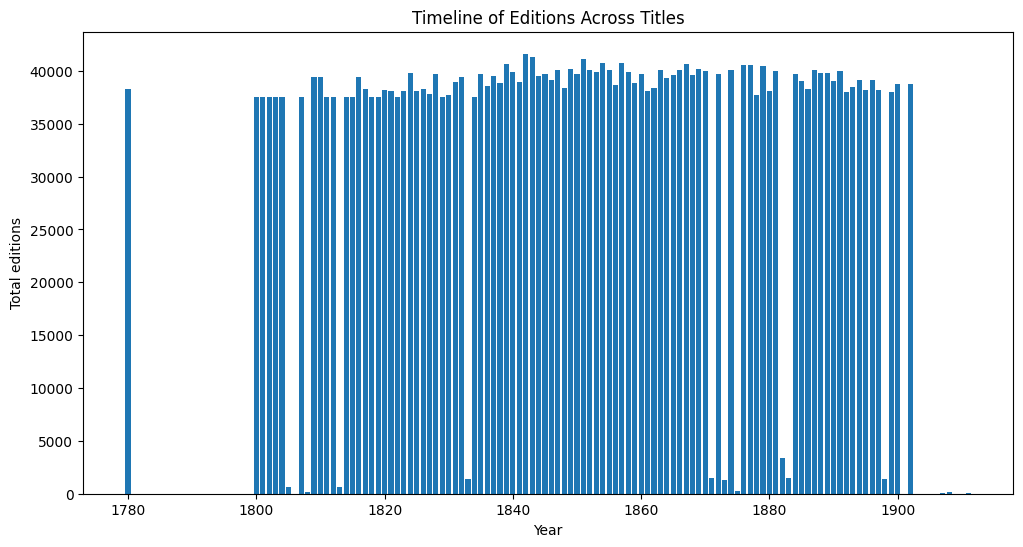

In [16]:

from collections import Counter

year_counts = Counter()
for n, data in T1.nodes(data=True):
    for y in data['years']:
        year_counts[y] += data['total_editions']

# Sort by year
years_sorted = sorted(year_counts)
counts_sorted = [year_counts[y] for y in years_sorted]

plt.figure(figsize=(12,6))
plt.bar(years_sorted, counts_sorted)
plt.xlabel("Year")
plt.ylabel("Total editions")
plt.title("Timeline of Editions Across Titles")
plt.show()


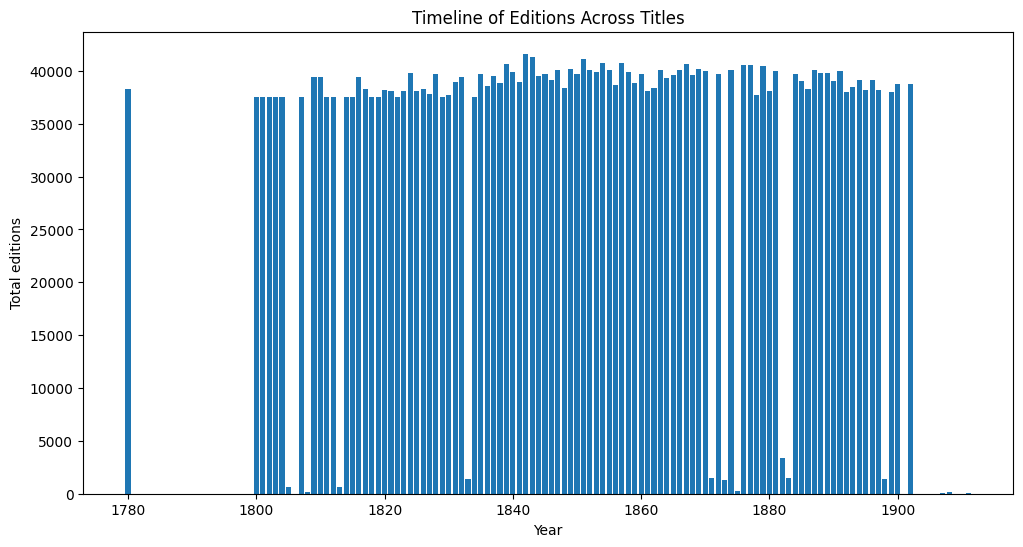

In [86]:

# Example: count editions per year [RUN IT ON T1 TOO)
from collections import Counter
import matplotlib.pyplot as plt

year_counts = Counter()
for n, data in T.nodes(data=True):
    for y in data['years']:
        year_counts[y] += data['total_editions']

# Sort by year
years_sorted = sorted(year_counts)
counts_sorted = [year_counts[y] for y in years_sorted]

plt.figure(figsize=(12,6))
plt.bar(years_sorted, counts_sorted)
plt.xlabel("Year")
plt.ylabel("Total editions")
plt.title("Timeline of Editions Across Titles")
plt.show()


In [90]:

import matplotlib.pyplot as plt
import networkx as nx

def plot_top_titles_timeline(T, metric='editions', top_n=10, figsize=(14,6), save_path=None):
    """
    Plot a timeline of top titles based on a given metric.
    
    Parameters:
    - T: multilingual graph
    - metric: 'earliest', 'editions', 'weighted_degree'
    - top_n: number of top titles to plot
    - figsize: figure size
    - save_path: if provided, saves plot to this PNG file
    """
    # --- Step 1: Select top titles ---
    if metric == 'earliest':
        titles_sorted = sorted(
            T.nodes,
            key=lambda n: min(T.nodes[n]['years']) if T.nodes[n]['years'] else float('inf')
        )
    elif metric == 'editions':
        titles_sorted = sorted(
            T.nodes,
            key=lambda n: T.nodes[n]['total_editions'],
            reverse=True
        )
    elif metric == 'weighted_degree':
        # Weighted degree = sum of edge weights for each node
        titles_sorted = sorted(
            T.nodes,
            key=lambda n: sum(d['weight'] for _, _, d in T.edges(n, data=True)),
            reverse=True
        )
    else:
        raise ValueError("metric must be 'earliest', 'editions', or 'weighted_degree'")
    
    top_titles = titles_sorted[:top_n]
    
    # --- Step 2: Prepare data for plotting ---
    plot_data = []
    for idx, title in enumerate(top_titles):
        data = T.nodes[title]
        years = sorted(data['years'])
        langs = data['languages']
        for y in years:
            for lang in langs:
                plot_data.append((idx, y, lang))
    
    if not plot_data:
        print("No data to plot!")
        return
    
    # --- Step 3: Map languages to colors ---
    lang_set = sorted({lang for _, _, lang in plot_data})
    colors = plt.cm.tab10.colors  # up to 10 languages
    lang_colors = {lang: colors[i % len(colors)] for i, lang in enumerate(lang_set)}
    
    # --- Step 4: Plot ---
    plt.figure(figsize=figsize)
    for idx, y, lang in plot_data:
        plt.scatter(y, idx, color=lang_colors[lang], label=lang, s=50)
    
    plt.yticks(range(len(top_titles)), top_titles)
    plt.xlabel("Year")
    plt.ylabel("Title")
    plt.title(f"Timeline of Top {top_n} Titles by '{metric}'")
    
    # --- Step 5: Legend ---
    handles = [plt.Line2D([0], [0], marker='o', color='w',
                          markerfacecolor=lang_colors[lang], markersize=8)
               for lang in lang_set]
    plt.legend(handles, lang_set, title="Language", bbox_to_anchor=(1.05,1), loc='upper left')
    plt.tight_layout()
    
    # --- Step 6: Save if path provided ---
    if save_path:
        plt.savefig(save_path, dpi=300)
        print(f"✅ Plot saved to {save_path}")
    
    plt.show()


/var/folders/v8/gbwh72kd5m90yqzsg20j5rdc0000gn/T/ipykernel_37083/1493632131.py:73: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


✅ Plot saved to top_editions_timeline.png


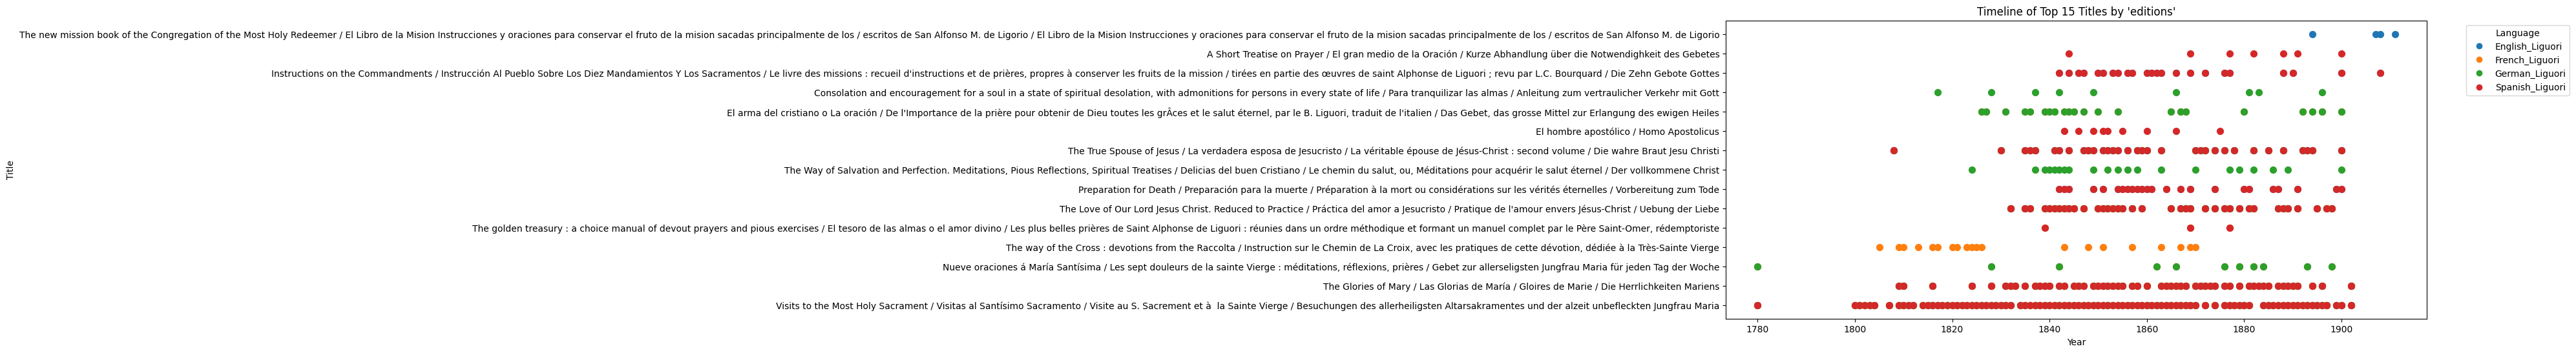

In [91]:

plot_top_titles_timeline(T, metric='editions', top_n=15, save_path="top_editions_timeline.png")


In [ ]:

# CHECK OUT THE PLOT BELOW in the OUTPUTS folder in the GitHub REPO (https://github.com/Galway-Coding/19CentLiguoriQuadrilingual)

/var/folders/v8/gbwh72kd5m90yqzsg20j5rdc0000gn/T/ipykernel_18311/1268061410.py:127: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


Saved timeline to liguori_top_editions_timeline_1.png


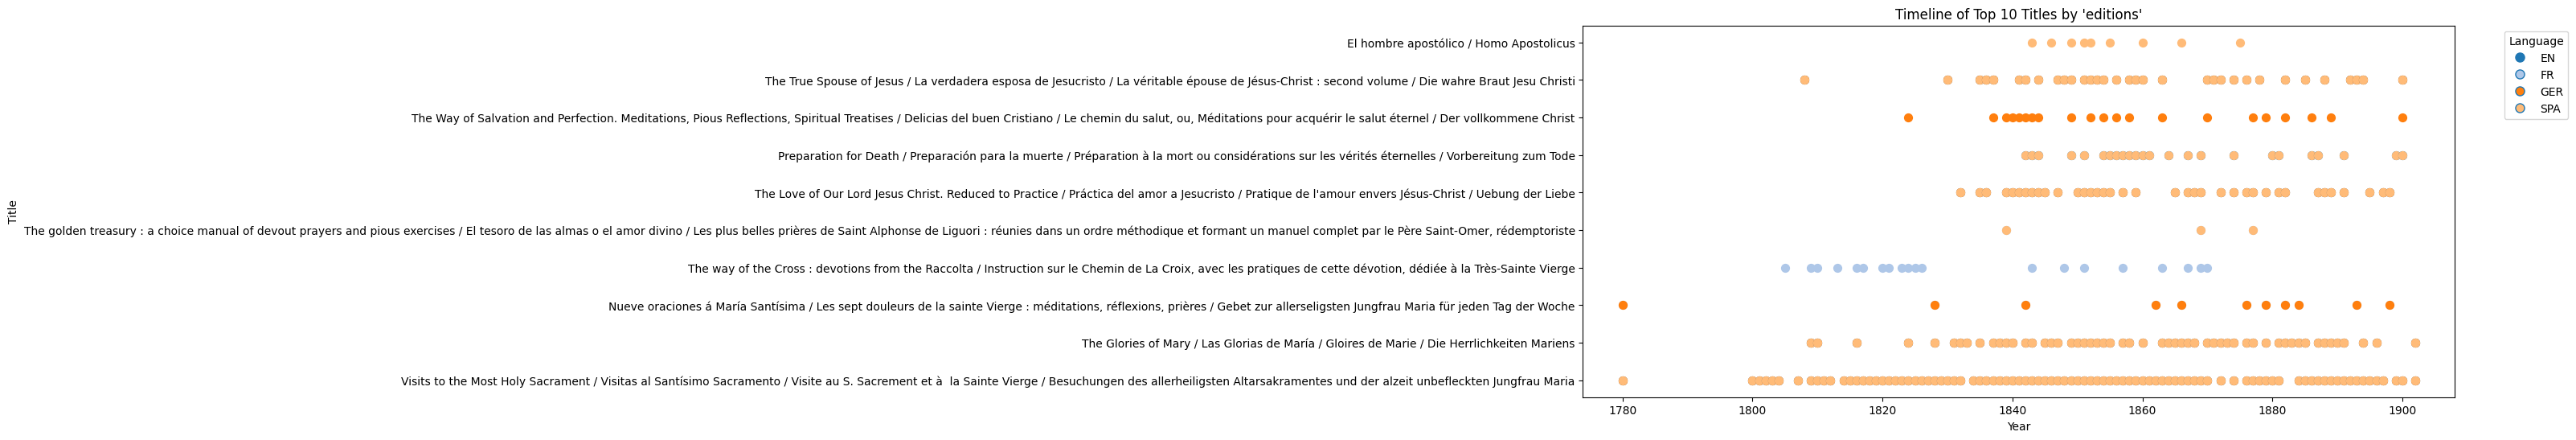

,title,years,languages,publishers,earliest,total_editions,weighted_degree
0,Visits to the Most Holy Sacrament / Visitas al...,"[1780, 1800, 1801, 1802, 1803, 1804, 1807, 180...","[EN, FR, GER, SPA]","[A. Brusi, Aguado, Aillaud, Alberts, Alphonsus...",1780.0,37500,1702
1,The Glories of Mary / Las Glorias de María / G...,"[1809, 1810, 1816, 1824, 1828, 1831, 1832, 183...","[EN, FR, GER, SPA]","[Aguado, Alberts, Apostolado de la Prensa, Avr...",1809.0,1282,1057
2,Nueve oraciones á María Santísima / Les sept d...,"[1780, 1828, 1842, 1862, 1866, 1876, 1879, 188...","[FR, GER]","[Fr. Pustet, Kirchheim, Laumann, Manz, Mechita...",1780.0,772,389
3,The way of the Cross : devotions from the Racc...,"[1805, 1809, 1810, 1813, 1816, 1817, 1820, 182...",[FR],"[ardant, barbou, barret, begyn, boissel, bouqu...",1805.0,648,148
4,The golden treasury : a choice manual of devou...,"[1839, 1869, 1877]","[FR, SPA]","[Riera, Sánchez, casterman, librairie internat...",1839.0,642,865
5,The Love of Our Lord Jesus Christ. Reduced to ...,"[1832, 1835, 1836, 1839, 1840, 1841, 1842, 184...","[EN, FR, GER, SPA]","[Alberts, Benziger Brothers, Bouret, Calleja, ...",1832.0,616,600
6,Preparation for Death / Preparación para la mu...,"[1842, 1843, 1844, 1849, 1851, 1854, 1855, 185...","[EN, SPA]","[Apostolado de la Prensa, Benziger Brothers, C...",1842.0,460,361
7,The Way of Salvation and Perfection. Meditatio...,"[1824, 1837, 1839, 1840, 1841, 1842, 1843, 184...",[GER],"[Benziger Brothers, Bonifaciusdruck, Cremer, F...",1824.0,336,290
8,The True Spouse of Jesus / La verdadera esposa...,"[1808, 1830, 1835, 1836, 1837, 1841, 1842, 184...","[EN, GER, SPA]","[Benziger Brothers, Calleja, Cremer, Fr. Puste...",1808.0,186,455
9,El hombre apostólico / Homo Apostolicus,"[1843, 1846, 1849, 1851, 1852, 1855, 1860, 186...",[SPA],"[Bouret, Garnier, Lasserre, Libreria Castellan...",1843.0,134,120


In [21]:
plot_title_timeline(
    T1,
    metric='editions',
    top_n=10,
    color_by='language',        # 'language' or 'publisher'
    point_size=50,
    figsize=(14, 6),
    save_path="liguori_top_editions_timeline_1.png"
)

/var/folders/v8/gbwh72kd5m90yqzsg20j5rdc0000gn/T/ipykernel_37083/1493632131.py:73: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


✅ Plot saved to top_earliest_timeline.png


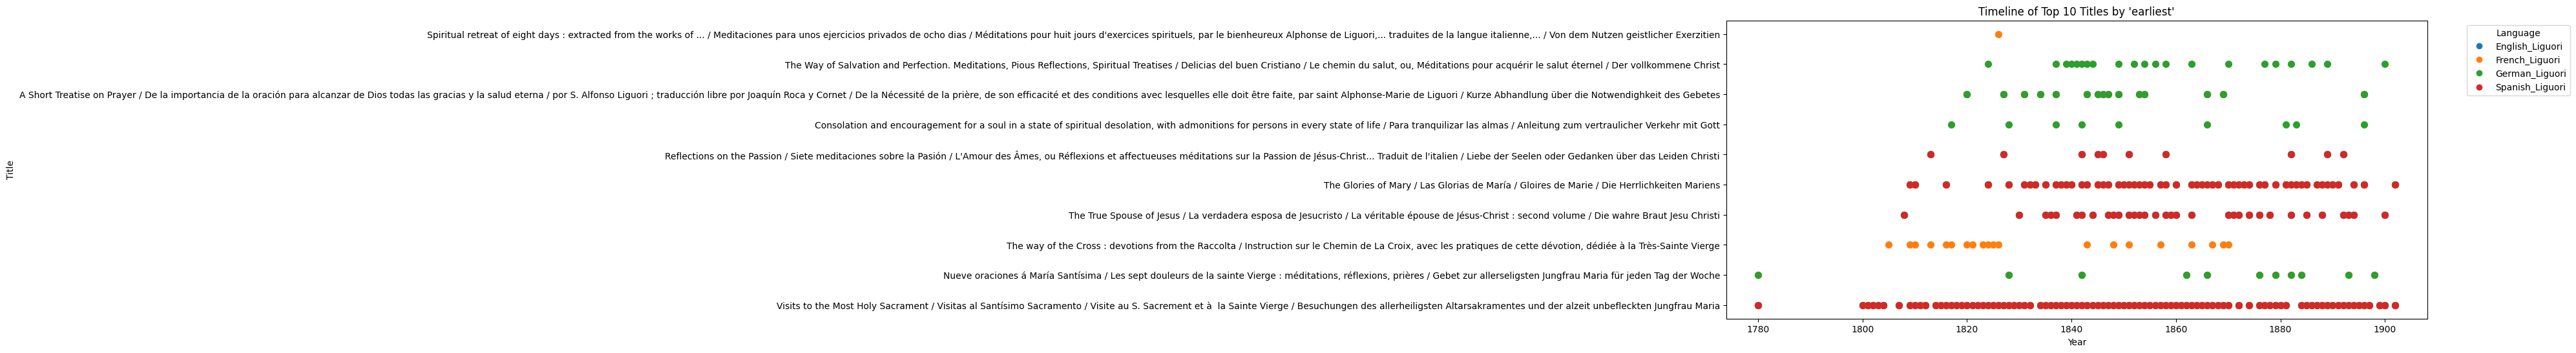

In [92]:

plot_top_titles_timeline(T, metric='earliest', top_n=10, save_path="top_earliest_timeline.png")

In [ ]:

# CHECK OUT THE PLOT BELOW in the OUTPUTS folder in the GitHub REPO (https://github.com/Galway-Coding/19CentLiguoriQuadrilingual)

/var/folders/v8/gbwh72kd5m90yqzsg20j5rdc0000gn/T/ipykernel_18311/1268061410.py:127: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


Saved timeline to liguori_earliest_titles_timeline_1.png


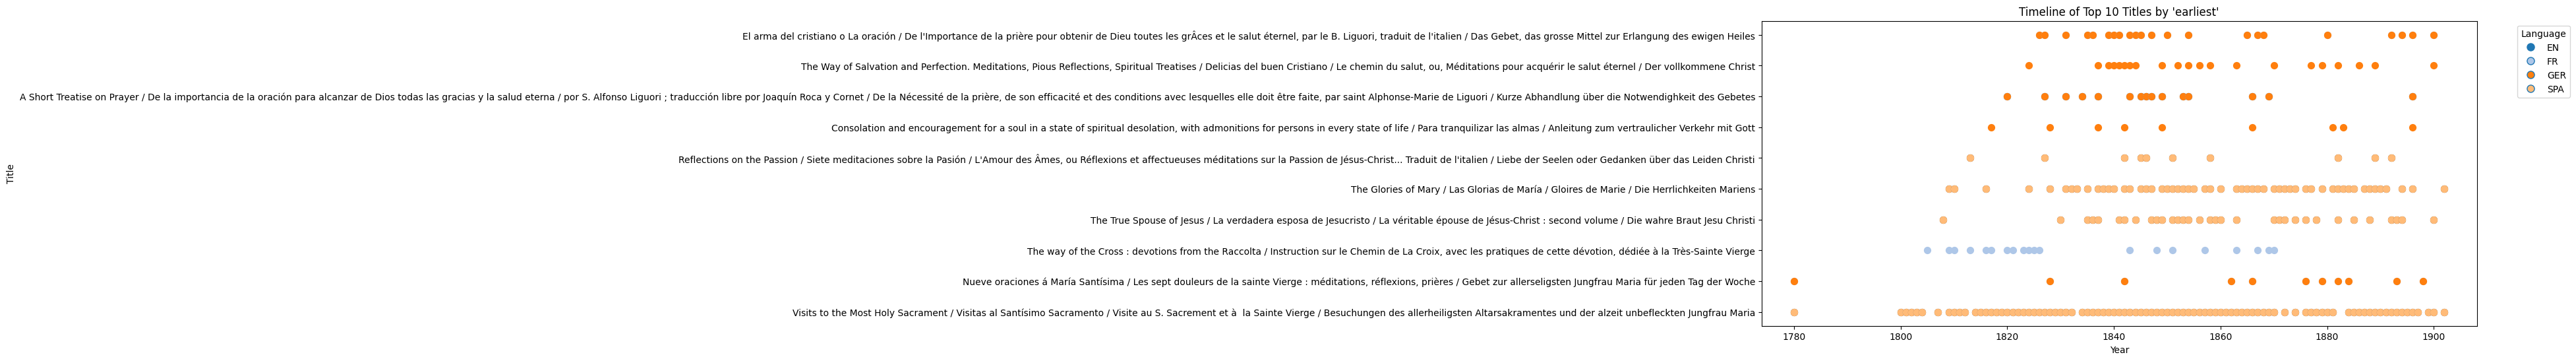

,title,years,languages,publishers,earliest,total_editions,weighted_degree
0,Visits to the Most Holy Sacrament / Visitas al...,"[1780, 1800, 1801, 1802, 1803, 1804, 1807, 180...","[EN, FR, GER, SPA]","[A. Brusi, Aguado, Aillaud, Alberts, Alphonsus...",1780.0,37500,1702
1,Nueve oraciones á María Santísima / Les sept d...,"[1780, 1828, 1842, 1862, 1866, 1876, 1879, 188...","[FR, GER]","[Fr. Pustet, Kirchheim, Laumann, Manz, Mechita...",1780.0,772,389
2,The way of the Cross : devotions from the Racc...,"[1805, 1809, 1810, 1813, 1816, 1817, 1820, 182...",[FR],"[ardant, barbou, barret, begyn, boissel, bouqu...",1805.0,648,148
3,The True Spouse of Jesus / La verdadera esposa...,"[1808, 1830, 1835, 1836, 1837, 1841, 1842, 184...","[EN, GER, SPA]","[Benziger Brothers, Calleja, Cremer, Fr. Puste...",1808.0,186,455
4,The Glories of Mary / Las Glorias de María / G...,"[1809, 1810, 1816, 1824, 1828, 1831, 1832, 183...","[EN, FR, GER, SPA]","[Aguado, Alberts, Apostolado de la Prensa, Avr...",1809.0,1282,1057
5,Reflections on the Passion / Siete meditacione...,"[1813, 1827, 1842, 1845, 1846, 1851, 1858, 188...","[EN, GER, SPA]","[Benziger Brothers, Burns and Oates, Catholic ...",1813.0,14,9
6,Consolation and encouragement for a soul in a ...,"[1817, 1828, 1837, 1842, 1849, 1866, 1881, 188...",[GER],"[Alberts, Laumann, LeRoux, Manz, Mechitaristes]",1817.0,130,295
7,A Short Treatise on Prayer / De la importancia...,"[1820, 1827, 1831, 1834, 1837, 1843, 1845, 184...","[EN, FR, GER]","[Benziger Brothers, Edward Dunigan & Brother, ...",1820.0,52,91
8,The Way of Salvation and Perfection. Meditatio...,"[1824, 1837, 1839, 1840, 1841, 1842, 1843, 184...",[GER],"[Benziger Brothers, Bonifaciusdruck, Cremer, F...",1824.0,336,290
9,El arma del cristiano o La oración / De l'Impo...,"[1826, 1827, 1831, 1835, 1836, 1839, 1840, 184...","[FR, GER]","[Alberts, Aschendorff, Collignon, Erziehungsan...",1826.0,130,236


In [22]:

plot_title_timeline(
    T1,
    metric='earliest',
    top_n=10,
    color_by='language',        # 'language' or 'publisher'
    point_size=50,
    figsize=(14, 6),
    save_path="liguori_earliest_titles_timeline_1.png"
)

/var/folders/v8/gbwh72kd5m90yqzsg20j5rdc0000gn/T/ipykernel_37083/1493632131.py:73: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


✅ Plot saved to top_weighted_degree_timeline.png


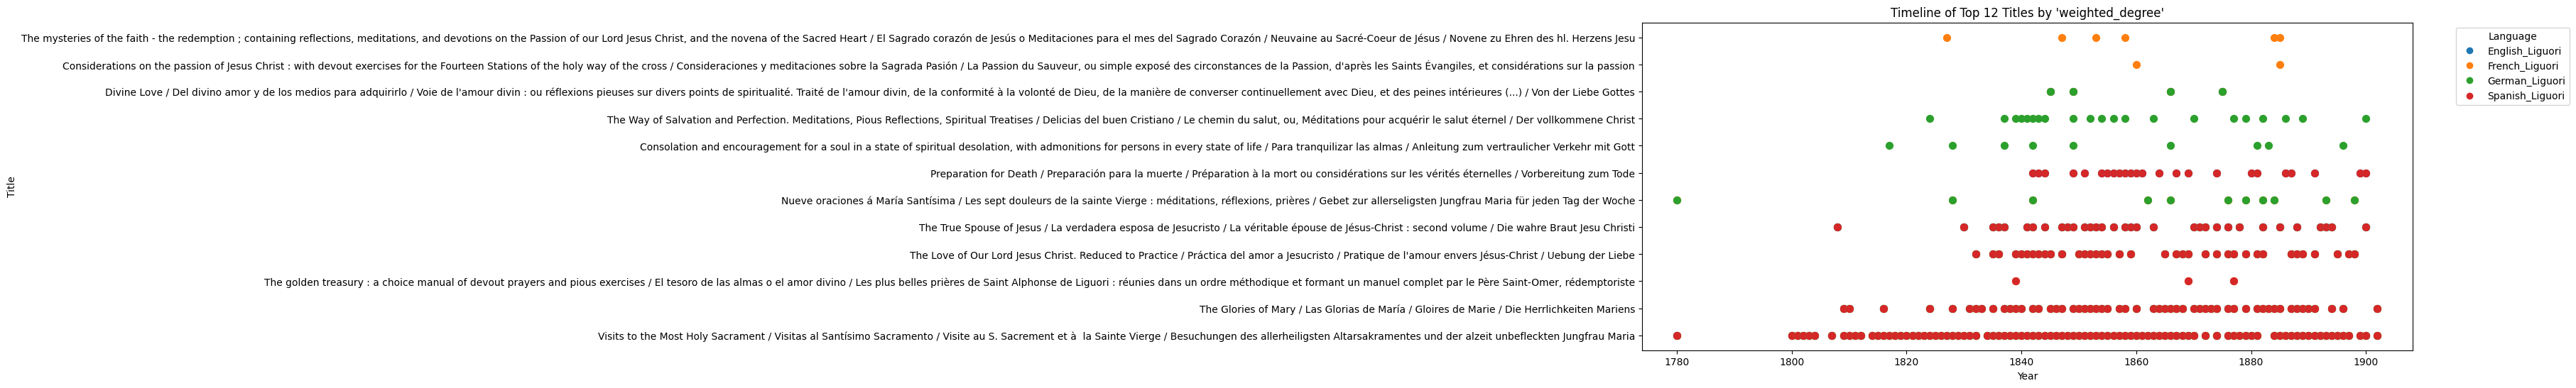

In [93]:

plot_top_titles_timeline(T, metric='weighted_degree', top_n=12, save_path="top_weighted_degree_timeline.png")

In [ ]:


# CHECK OUT THE PLOT BELOW in the OUTPUTS folder in the GitHub REPO (https://github.com/Galway-Coding/19CentLiguoriQuadrilingual)

/var/folders/v8/gbwh72kd5m90yqzsg20j5rdc0000gn/T/ipykernel_18311/1268061410.py:127: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


Saved timeline to liguori_top_degree_titles_timeline_1.png


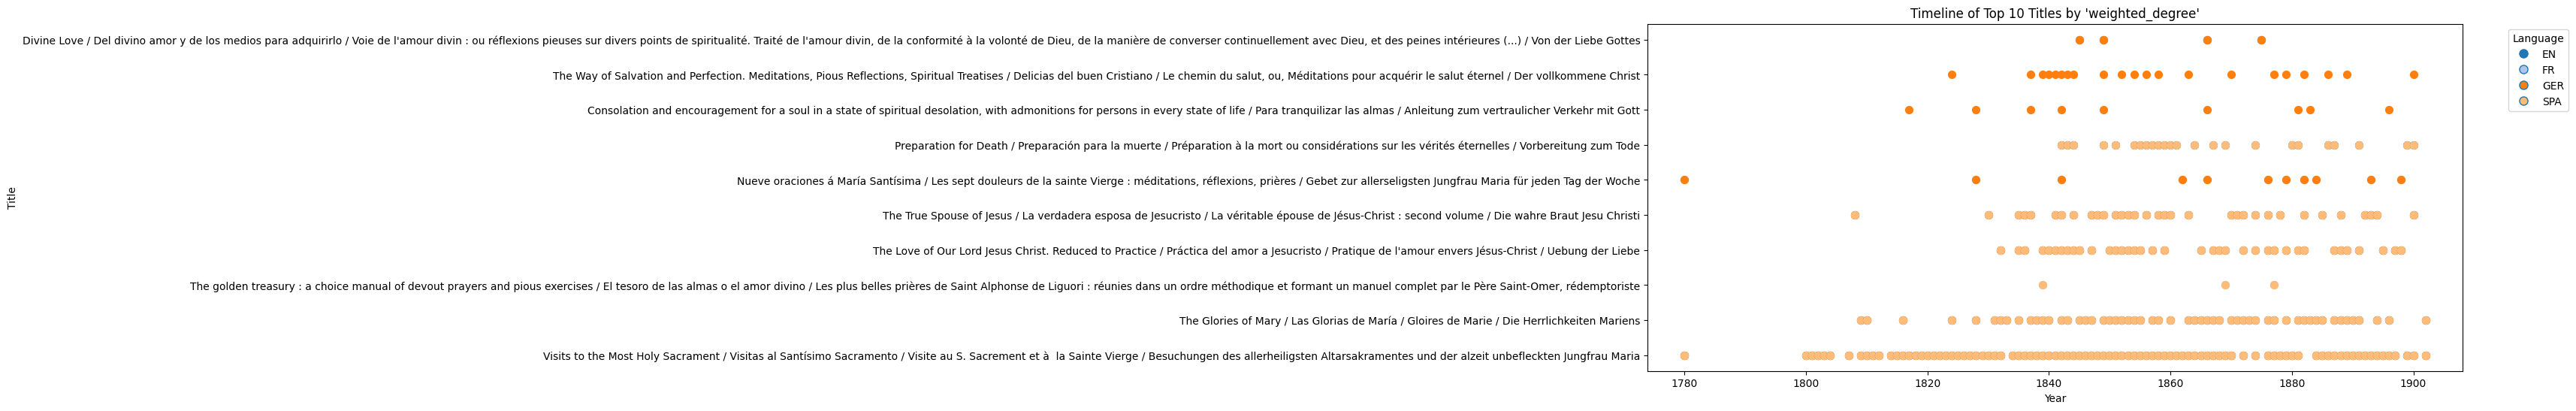

,title,years,languages,publishers,earliest,total_editions,weighted_degree
0,Visits to the Most Holy Sacrament / Visitas al...,"[1780, 1800, 1801, 1802, 1803, 1804, 1807, 180...","[EN, FR, GER, SPA]","[A. Brusi, Aguado, Aillaud, Alberts, Alphonsus...",1780.0,37500,1702
1,The Glories of Mary / Las Glorias de María / G...,"[1809, 1810, 1816, 1824, 1828, 1831, 1832, 183...","[EN, FR, GER, SPA]","[Aguado, Alberts, Apostolado de la Prensa, Avr...",1809.0,1282,1057
2,The golden treasury : a choice manual of devou...,"[1839, 1869, 1877]","[FR, SPA]","[Riera, Sánchez, casterman, librairie internat...",1839.0,642,865
3,The Love of Our Lord Jesus Christ. Reduced to ...,"[1832, 1835, 1836, 1839, 1840, 1841, 1842, 184...","[EN, FR, GER, SPA]","[Alberts, Benziger Brothers, Bouret, Calleja, ...",1832.0,616,600
4,The True Spouse of Jesus / La verdadera esposa...,"[1808, 1830, 1835, 1836, 1837, 1841, 1842, 184...","[EN, GER, SPA]","[Benziger Brothers, Calleja, Cremer, Fr. Puste...",1808.0,186,455
5,Nueve oraciones á María Santísima / Les sept d...,"[1780, 1828, 1842, 1862, 1866, 1876, 1879, 188...","[FR, GER]","[Fr. Pustet, Kirchheim, Laumann, Manz, Mechita...",1780.0,772,389
6,Preparation for Death / Preparación para la mu...,"[1842, 1843, 1844, 1849, 1851, 1854, 1855, 185...","[EN, SPA]","[Apostolado de la Prensa, Benziger Brothers, C...",1842.0,460,361
7,Consolation and encouragement for a soul in a ...,"[1817, 1828, 1837, 1842, 1849, 1866, 1881, 188...",[GER],"[Alberts, Laumann, LeRoux, Manz, Mechitaristes]",1817.0,130,295
8,The Way of Salvation and Perfection. Meditatio...,"[1824, 1837, 1839, 1840, 1841, 1842, 1843, 184...",[GER],"[Benziger Brothers, Bonifaciusdruck, Cremer, F...",1824.0,336,290
9,Divine Love / Del divino amor y de los medios ...,"[1845, 1849, 1866, 1875]","[EN, FR, GER]","[Cremer, H. & C. McGrath, James Duffy, Manz, c...",1845.0,16,269


In [23]:

plot_title_timeline(
    T1,
    metric='weighted_degree',
    top_n=10,
    color_by='language',        # 'language' or 'publisher'
    point_size=50,
    figsize=(14, 6),
    save_path="liguori_top_degree_titles_timeline_1.png"
)

In [ ]:

# COMMUNITIES & CLUSTERS


In [ ]:

# Compute communities and cluster summaries for publication-ready interpretation.
import pickle, networkx as nx, pandas as pd, numpy as np
from collections import Counter, defaultdict

# path="Liguori_Titles_19th_Century_2.pkl"
# Not so much the titles are at stake here as the publishers so path="Liguori_19th_Century.pkl" or combined1 from memory
# with open(path,"rb") as f:
    # T=pickle.load(f)

# Convert to undirected for community detection
U = nx.Graph()

for u, v, data in combined1.edges(data=True):
    w = data.get('weight', 1)
    
    # make sure w is numeric
    try:
        w = float(w)
    except:
        w = 1.0
    
    if U.has_edge(u, v):
        U[u][v]['weight'] += w
    else:
        U.add_edge(u, v, weight=w)

        U.add_edge(u,v,weight=w)

# Use greedy modularity communities
from networkx.algorithms.community import greedy_modularity_communities
communities = list(greedy_modularity_communities(U, weight='weight'))

In [71]:

def sum_editions(pub):
    ed = pub["editions"]
    if isinstance(ed, list):
        return sum(ed)
    elif pd.notnull(ed):
        return ed
    else:
        return 0

In [ ]:

# Build node dataframe
rows = []

for n,data in combined1.nodes(data=True):
    # years = sorted(data.get('years', []))
    # earliest = min(years) if years else None
    rows.append({
        # 'title': n,
        'publisher': n,
        # 'total_editions': data.get('total_editions', 0),
        'publications': data.get('publications', []),
        # 'years': years,
        # 'earliest': earliest,
        # 'languages': data.get('languages', [])
        'magnitude': data.get('magnitude', 1),
        'source_graph': data.get('source_graph', [])
    })
    
df = pd.DataFrame(rows).set_index('publisher')

# Assign community id per node
comm_assign = {}

for i, comm in enumerate(communities):
    for node in comm:
        comm_assign[node] = i

df['community'] = df.index.map(lambda x: comm_assign.get(x, -1))

# Summarize communities
comm_summaries = []
community_dfs = []

for i, comm in enumerate(communities):
    summary = {}
    members = list(comm)
    size = len(members)
    # total_ed = df.loc[members, 'total_editions'].sum()
    # top_titles = df.loc[members].sort_values('total_editions', ascending=False).head(6).reset_index()[['title','total_editions']].to_dict(orient='records')
    # langs = Counter([lang for node in members for lang in df.at[node,'languages']])
    # years_list = [y for node in members for y in (df.at[node,'years'] or [])]
    # earliest_years = [df.at[node,'earliest'] for node in members if df.at[node,'earliest'] is not None]
    # median_earliest = np.median(earliest_years) if earliest_years else None
    total_number_titles = df.loc[members, "publications"].apply(len).sum()
    total_editions = df.loc[members, "publications"].apply(
    lambda pubs: sum(sum_editions(p) for p in pubs)
    ).sum()
    unique_source_graphs = set().union(*df.loc[members, "source_graph"])

    summary['community_id'] = i

    summary['size'] = size

    summary['total_number_titles'] = total_number_titles

    summary['total_editions'] = total_editions

    summary['unique_source_graphs'] = unique_source_graphs
    
    community_df = centrality_df_pub[centrality_df_pub['Publisher'].isin(members)]

    community_dfs.append(community_df)
    
    centrality_cols = [
        "Unweighted_Total", "Weighted_Total",
        "Betweenness_Unweighted", "Betweenness_Weighted",
        "Closeness_Unweighted", "Closeness_Weighted",
        "Eigenvector_Unweighted", "Eigenvector_Weighted"
    ]
    
    for col in centrality_cols:
        summary[f"{col}_mean"] = community_df[col].mean()
        summary[f"{col}_median"] = community_df[col].median()
        summary[f"{col}_max"] = community_df[col].max()
        
        # Optionally, who has the max
        max_idx = community_df[col].idxmax()
        summary[f"{col}_max_member"] = max_idx

    comm_summaries.append(summary)

    # comm_summaries.append({
        # 'community_id': i,
        # 'size': size,
        # 'total_number_titles': total_number_titles,
        # 'total_editions': int(total_editions),
        # 'top_titles': top_titles,
        # 'language_counts': dict(langs),
        # 'median_earliest': float(median_earliest) if median_earliest is not None else None       
    # })

In [77]:

def convert_numpy(obj):
    if isinstance(obj, (np.integer, np.int64, np.int32)):
        return int(obj)
    elif isinstance(obj, (np.floating, np.float64, np.float32)):
        return float(obj)
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    raise TypeError(f"Type {type(obj)} not serializable")

In [84]:

with open('liguori_19th_community_summaries.pkl', 'wb') as fay:
    pickle.dump(comm_summaries, fay)

In [75]:

comm_summaries = sorted(comm_summaries, key=lambda x: x['size'], reverse=True)


In [76]:

comm_summaries

[{'community_id': 0,
  'size': 190,
  'total_number_titles': 502,
  'total_editions': 1435.0,
  'unique_source_graphs': {'English_Liguori',
   'French_Liguori',
   'German_Liguori',
   'Spanish_Liguori'},
  'Unweighted_Total_mean': 245.57894736842104,
  'Unweighted_Total_median': 244.5,
  'Unweighted_Total_max': 1146,
  'Unweighted_Total_max_member': 126,
  'Weighted_Total_mean': 621.8789473684211,
  'Weighted_Total_median': 430.5,
  'Weighted_Total_max': 4843.0,
  'Weighted_Total_max_member': 126,
  'Betweenness_Unweighted_mean': 0.0028028442359427177,
  'Betweenness_Unweighted_median': 0.00013680396967037374,
  'Betweenness_Unweighted_max': 0.15529243217276112,
  'Betweenness_Unweighted_max_member': 126,
  'Betweenness_Weighted_mean': 0.004580247870713745,
  'Betweenness_Weighted_median': 0.00047760286537929127,
  'Betweenness_Weighted_max': 0.1365431389115699,
  'Betweenness_Weighted_max_member': 126,
  'Closeness_Unweighted_mean': 0.3626460435562263,
  'Closeness_Unweighted_median'

In [70]:

with open('liguori_19th_cent_publisher_communities.pkl', 'wb') as foo:
    pickle.dump(communities, foo)

In [85]:

comm_summaries = sorted(comm_summaries, key=lambda x: x['Betweenness_Weighted_mean'], reverse=True)

In [86]:

comm_summaries

[{'community_id': 0,
  'size': 190,
  'total_number_titles': 502,
  'total_editions': 1435.0,
  'unique_source_graphs': {'English_Liguori',
   'French_Liguori',
   'German_Liguori',
   'Spanish_Liguori'},
  'Unweighted_Total_mean': 245.57894736842104,
  'Unweighted_Total_median': 244.5,
  'Unweighted_Total_max': 1146,
  'Unweighted_Total_max_member': 126,
  'Weighted_Total_mean': 621.8789473684211,
  'Weighted_Total_median': 430.5,
  'Weighted_Total_max': 4843.0,
  'Weighted_Total_max_member': 126,
  'Betweenness_Unweighted_mean': 0.0028028442359427177,
  'Betweenness_Unweighted_median': 0.00013680396967037374,
  'Betweenness_Unweighted_max': 0.15529243217276112,
  'Betweenness_Unweighted_max_member': 126,
  'Betweenness_Weighted_mean': 0.004580247870713745,
  'Betweenness_Weighted_median': 0.00047760286537929127,
  'Betweenness_Weighted_max': 0.1365431389115699,
  'Betweenness_Weighted_max_member': 126,
  'Closeness_Unweighted_mean': 0.3626460435562263,
  'Closeness_Unweighted_median'

In [ ]:

for n,data in combined1.nodes(data=True):
    # years = sorted(data.get('years', []))
    # earliest = min(years) if years else None
    rows.append({
        # 'title': n,
        'publisher': n,
        # 'total_editions': data.get('total_editions', 0),
        'publications': data.get('publications', []),
        # 'years': years,
        # 'earliest': earliest,
        # 'languages': data.get('languages', [])
        'magnitude': data.get('magnitude', 1),
        'source_graph': data.get('source_graph', [])
    })
    
df = pd.DataFrame(rows).set_index('publisher')

# Assign community id per node
comm_assign = {}

for i, comm in enumerate(communities):
    for node in comm:
        comm_assign[node] = i

df['community'] = df.index.map(lambda x: comm_assign.get(x, -1))

In [94]:

import numpy as np
import pandas as pd
from collections import Counter

def community_heterogeneity(G, df, community): # df is the df in the cell above
    """
    Compute heterogeneity for a community.
    
    Parameters
    ----------
    G : networkx.Graph or DiGraph
        The full graph.
    df : pd.DataFrame
        Node DataFrame, must contain 'Publisher' column and 'source_graph' list.
        Index can be default or Publisher column.
    members : list
        List of node names in the community (must match df['Publisher']).
    
    Returns
    -------
    dict
        Dictionary with:
            - 'entropy': Shannon entropy of source graphs
            - 'cross_source_fraction': fraction of edges between nodes with no shared source
            - 'heterogeneity_score': entropy * cross_source_fraction
            - 'n_members': number of members
    """
    # Filter the DataFrame for the community
    members = list(community)
    community_df = df[df['Publisher'].isin(members)]
    
    # ---------- 1. Shannon entropy of source graphs ----------
    all_sources = [src for node in members for src in community_df.loc[community_df['Publisher'] == node, 'source_graph'].values[0]]
    counts = np.array(list(Counter(all_sources).values()))
    probs = counts / counts.sum() if counts.sum() > 0 else np.array([1])
    entropy = -np.sum(probs * np.log2(probs))
    
    # ---------- 2. Fraction of cross-source edges ----------
    # Subgraph of the community
    G_comm = G.subgraph(members)
    cross_edges = 0
    for u, v in G_comm.edges():
        sources_u = set(community_df.loc[community_df['Publisher'] == u, 'source_graph'].values[0])
        sources_v = set(community_df.loc[community_df['Publisher'] == v, 'source_graph'].values[0])
        if len(sources_u & sources_v) == 0:  # no overlap
            cross_edges += 1
    total_edges = G_comm.number_of_edges() if G_comm.number_of_edges() > 0 else 1
    cross_source_fraction = cross_edges / total_edges
    
    # ---------- 3. Combined heterogeneity ----------
    heterogeneity_score = entropy * cross_source_fraction
    
    return {
        'n_members': len(members),
        'entropy': entropy,
        'cross_source_fraction': cross_source_fraction,
        'heterogeneity_score': heterogeneity_score
    }


In [102]:

centrality_df_pub['source_graph'] = centrality_df_pub['Publisher'].map(lambda x: df.loc[x, 'source_graph'])


In [103]:

comm_heterogeneity_list = []

for i, community in enumerate(communities):
    het = community_heterogeneity(combined1, centrality_df_pub, community)
    het['community_id'] = i
    comm_heterogeneity_list.append(het)

In [104]:
comm_heterogeneity_list

[{'n_members': 190,
  'entropy': 1.4154537240340241,
  'cross_source_fraction': 0.6507239796175773,
  'heterogeneity_score': 0.9210696802679402,
  'community_id': 0},
 {'n_members': 159,
  'entropy': 1.9694422975589059,
  'cross_source_fraction': 0.7046698872785829,
  'heterogeneity_score': 1.3878066818225077,
  'community_id': 1},
 {'n_members': 21,
  'entropy': 0.5916727785823275,
  'cross_source_fraction': 0.18556701030927836,
  'heterogeneity_score': 0.10979494860290613,
  'community_id': 2},
 {'n_members': 21,
  'entropy': 1.181899057917561,
  'cross_source_fraction': 0.46296296296296297,
  'heterogeneity_score': 0.5471754897766486,
  'community_id': 3},
 {'n_members': 3,
  'entropy': -0.0,
  'cross_source_fraction': 0.0,
  'heterogeneity_score': -0.0,
  'community_id': 4},
 {'n_members': 3,
  'entropy': -0.0,
  'cross_source_fraction': 0.0,
  'heterogeneity_score': -0.0,
  'community_id': 5},
 {'n_members': 2,
  'entropy': -0.0,
  'cross_source_fraction': 0.0,
  'heterogeneity_sc

In [114]:

sorted_heterogeneity_list = sorted(comm_heterogeneity_list, key=lambda x: x['heterogeneity_score'], reverse=True)

In [115]:
sorted_heterogeneity_list

[{'n_members': 159,
  'entropy': 1.9694422975589059,
  'cross_source_fraction': 0.7046698872785829,
  'heterogeneity_score': 1.3878066818225077,
  'community_id': 1},
 {'n_members': 190,
  'entropy': 1.4154537240340241,
  'cross_source_fraction': 0.6507239796175773,
  'heterogeneity_score': 0.9210696802679402,
  'community_id': 0},
 {'n_members': 21,
  'entropy': 1.181899057917561,
  'cross_source_fraction': 0.46296296296296297,
  'heterogeneity_score': 0.5471754897766486,
  'community_id': 3},
 {'n_members': 21,
  'entropy': 0.5916727785823275,
  'cross_source_fraction': 0.18556701030927836,
  'heterogeneity_score': 0.10979494860290613,
  'community_id': 2},
 {'n_members': 3,
  'entropy': -0.0,
  'cross_source_fraction': 0.0,
  'heterogeneity_score': -0.0,
  'community_id': 4},
 {'n_members': 3,
  'entropy': -0.0,
  'cross_source_fraction': 0.0,
  'heterogeneity_score': -0.0,
  'community_id': 5},
 {'n_members': 2,
  'entropy': -0.0,
  'cross_source_fraction': 0.0,
  'heterogeneity_sc

In [105]:

def find_node_community(node, communities):
    for i, members in enumerate(communities):
        if node in members:
            return i  # or return members if you want the full list
    return None  # node not found


node_name = 'mame'
community_id = find_node_community(node_name, communities)
print(f"Node {node_name} belongs to community {community_id}")


Node mame belongs to community 0


In [119]:

# CHECKING WHICH COMMUNITY EACH TOP-20 WEIGHTED BETWEENNESS NODE BELONGS IN
node_names = ['mame', 'Manz', 'Benziger Brothers', 'Aguado', 'gaume', 'casterman', 'Bossange', 'caron', 'James Duffy', 'maitre', 'Laumann', 'Rieger', 'leday', \
             'Librería Religiosa', 'fischer', 'J.B. Piet', 'Herzog', 'guyot', 'P.J. Kenedy', 'Richard Grace']

for node in node_names:
    community_id = find_node_community(node, communities)
    print(f"Node {node} belongs to community {community_id}")


Node mame belongs to community 0
Node Manz belongs to community 1
Node Benziger Brothers belongs to community 1
Node Aguado belongs to community 0
Node gaume belongs to community 1
Node casterman belongs to community 1
Node Bossange belongs to community 0
Node caron belongs to community 0
Node James Duffy belongs to community 1
Node maitre belongs to community 0
Node Laumann belongs to community 0
Node Rieger belongs to community 1
Node leday belongs to community 0
Node Librería Religiosa belongs to community 1
Node fischer belongs to community 0
Node J.B. Piet belongs to community 2
Node Herzog belongs to community 0
Node guyot belongs to community 0
Node P.J. Kenedy belongs to community 1
Node Richard Grace belongs to community 1


In [108]:

# CHECKING WHICH COMMUNITY EACH TOP-13 WEIGHTED CLOSENESS NODE BELONGS IN
node_names = ['Benziger Brothers', 'Calleja', 'Eberle & Rickenbach', 'mame', 'Schöningh', 'Ostendorff', 'Avrial', 'maitre', 'desclee', 	'Librería Religiosa de Enrique Hernández', 'Löwenberg', 'Baena', 'Pfeiffer']

for node in node_names:
    community_id = find_node_community(node, communities)
    print(f"Node {node} belongs to community {community_id}")


Node Benziger Brothers belongs to community 1
Node Calleja belongs to community 1
Node Eberle & Rickenbach belongs to community 0
Node mame belongs to community 0
Node Schöningh belongs to community 0
Node Ostendorff belongs to community 0
Node Avrial belongs to community 0
Node maitre belongs to community 0
Node desclee belongs to community 0
Node Librería Religiosa de Enrique Hernández belongs to community 0
Node Löwenberg belongs to community 0
Node Baena belongs to community 0
Node Pfeiffer belongs to community 0


In [110]:


# CHECKING WHICH COMMUNITY EACH TOP-13 WEIGHTED EIGENVECTOR NODE BELONGS IN
node_names = ['Manz', 'mame', 'casterman', 	'Laumann', 	'barbou', 'Barth', 	'ardant', 'Benziger Brothers', 	'Fr. Pustet', 'rittler', 'Garnier',	'librairie internationale catholique', 'Pons y Cía']

for node in node_names:
    community_id = find_node_community(node, communities)
    print(f"Node {node} belongs to community {community_id}")


Node Manz belongs to community 1
Node mame belongs to community 0
Node casterman belongs to community 1
Node Laumann belongs to community 0
Node barbou belongs to community 0
Node Barth belongs to community 0
Node ardant belongs to community 0
Node Benziger Brothers belongs to community 1
Node Fr. Pustet belongs to community 3
Node rittler belongs to community 1
Node Garnier belongs to community 1
Node librairie internationale catholique belongs to community 1
Node Pons y Cía belongs to community 1


In [111]:

# NODES FROM THE FOURTH  MOST HETEROGENEOUS COMMUNITY AND THEIR SOURCE GRAPH
for node in communities[2]:
    print(node, 'from', combined1.nodes[node]['source_graph'])

lejeune from ['French_Liguori']
fauvet jaune from ['French_Liguori']
saintour from ['French_Liguori']
picut from ['French_Liguori']
Augustin Coté & Co. from ['English_Liguori']
Felix O'Rourke from ['English_Liguori']
ignon from ['French_Liguori']
J.B. Piet from ['English_Liguori']
darnaultmaurant from ['French_Liguori']
montal from ['French_Liguori']
vignancour from ['French_Liguori']
chaul from ['French_Liguori']
librairie de la socit typographique from ['French_Liguori']
fid anner from ['French_Liguori']
hissette from ['French_Liguori']
bouquerel from ['French_Liguori']
goy from ['French_Liguori']
girard from ['French_Liguori']
boissel from ['French_Liguori']
begyn from ['French_Liguori']
barret from ['French_Liguori']


In [112]:

# NODES FROM THE THIRD MOST HETEROGENEOUS COMMUNITY AND THEIR SOURCE GRAPH
for node in communities[3]:
    print(node, 'from', combined1.nodes[node]['source_graph'])

bureau de la des livres de piété from ['French_Liguori']
Erziehungsanstalt from ['German_Liguori']
Fr. Pustet from ['English_Liguori', 'German_Liguori']
bourguetcalas from ['French_Liguori']
libraire ecclsiastique from ['French_Liguori']
Stamm from ['German_Liguori']
Aschendorff from ['German_Liguori']
dureau from ['French_Liguori']
société de saintvictor from ['French_Liguori']
thomasmalvin from ['French_Liguori']
Willems from ['German_Liguori']
Kirsch from ['German_Liguori']
ponston from ['French_Liguori']
paravia from ['French_Liguori']
Collignon from ['German_Liguori']
bitsch from ['French_Liguori']
gauthier from ['French_Liguori']
pillot from ['French_Liguori']
prudhomme from ['French_Liguori']
aimburdet from ['French_Liguori']
Jacobi from ['German_Liguori']


In [118]:

# THE LOWEST HETEROGENEITY COMMUNITIES
for i in range(4, 8):
    for node in communities[i]:
        print(node, 'from', combined1.nodes[node]['source_graph'])

pouy from ['French_Liguori']
maison des pères rédemptoristes from ['French_Liguori']
aux bureaux de la sainte famille from ['French_Liguori']
paul mellier from ['French_Liguori']
lagny from ['French_Liguori']
parent-desbarres from ['French_Liguori']
jacquot from ['French_Liguori']
tubergue from ['French_Liguori']
vaissire from ['French_Liguori']
perol from ['French_Liguori']


In [127]:

# PUBLICATIONS AND SIZES OF NODES IN THE THIRD MOST HETEREGENEOUS NETWORK
for node in communities[3]:
    print(node, "publications", combined1.nodes[node]["publications"], "\n", "size", combined1.nodes[node]["magnitude"], "", "\n")

bureau de la des livres de piété publications [{'title': "L'Amour des Âmes, ou Réflexions et affectueuses méditations sur la Passion de Jésus-Christ, par S. Alphonse-Marie de Liguory, traduit de l'italien par M. Verdier,...", 'years': [1833.0, 1834], 'editions': [2], 'publisher': ['bureau de la des livres de piété'], 'translator': ['verdier, j'], 'place': ['Clermont']}, {'title': "De la Communion fréquente, par S. Alphonse-Marie de Liguory, ou Réponses de l'auteur aux objections publiées sous le nom d'Aristase Cyprien au sujet de la fréquente communion. Traduit de l'italien", 'years': [1831.0, nan], 'editions': [1], 'publisher': ['bureau de la des livres de piété'], 'translator': ['nan'], 'place': ['Clermont']}, {'title': 'De la Nécessité de la prière, de son efficacité et des conditions avec lesquelles elle doit être faite, par saint Alphonse-Marie de Liguori', 'years': [1831.0, nan], 'editions': [1], 'publisher': ['bureau de la des livres de piété'], 'translator': ['nan'], 'place': [